## Part-I : CNN

In [1]:
!unzip cnn_dataset.zip -d cnn_dataset

Streaming output truncated to the last 5000 lines.
  inflating: cnn_dataset/vehicles/5499.jpg  
  inflating: cnn_dataset/vehicles/55.jpg  
  inflating: cnn_dataset/vehicles/550.jpg  
  inflating: cnn_dataset/vehicles/5500.jpg  
  inflating: cnn_dataset/vehicles/5501.jpg  
  inflating: cnn_dataset/vehicles/5502.jpg  
  inflating: cnn_dataset/vehicles/5503.jpg  
  inflating: cnn_dataset/vehicles/5504.jpg  
  inflating: cnn_dataset/vehicles/5505.jpg  
  inflating: cnn_dataset/vehicles/5506.jpg  
  inflating: cnn_dataset/vehicles/5507.jpg  
  inflating: cnn_dataset/vehicles/5508.jpg  
  inflating: cnn_dataset/vehicles/5509.jpg  
  inflating: cnn_dataset/vehicles/551.jpg  
  inflating: cnn_dataset/vehicles/5510.jpg  
  inflating: cnn_dataset/vehicles/5511.jpg  
  inflating: cnn_dataset/vehicles/5512.jpg  
  inflating: cnn_dataset/vehicles/5513.jpg  
  inflating: cnn_dataset/vehicles/5514.jpg  
  inflating: cnn_dataset/vehicles/5515.jpg  
  inflating: cnn_dataset/vehicles/5516.jpg  
  inflat

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision import datasets, transforms
from torchvision.datasets import ImageFolder
from torch.optim import lr_scheduler

from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
%matplotlib inline
import cv2
import time
import os
import tqdm

# **Set Device**

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# **1. Data Preprocessing:**


## a. Read, preprocess, and print the main statistics about the dataset.

In [4]:
# Data transformation
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.466), (0.229, 0.224, 0.255))
])

# Root directory of the data stored
root_dir = '/content/cnn_dataset'


# Load the dataset
dataset = datasets.ImageFolder(root=root_dir, transform=transform)

print("Number of samples:", len(dataset))
print("Number of classes:", len(dataset.classes))
print("Class labels:", dataset.classes)

Number of samples: 30000
Number of classes: 3
Class labels: ['dogs', 'food', 'vehicles']


## b. Data Visualization:

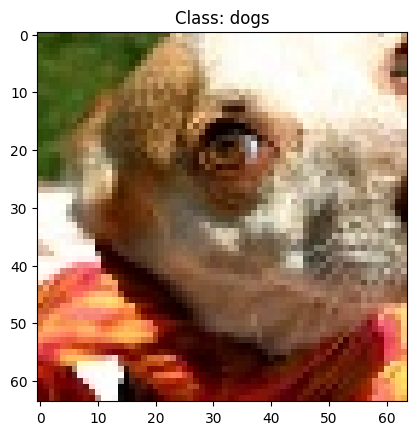

In [5]:
# Visualise sample image without transformation

temp = datasets.ImageFolder(root=root_dir)

sample_image, sample_label = temp[100]
plt.imshow(sample_image)
plt.title(f"Class: {dataset.classes[sample_label]}")
plt.show()

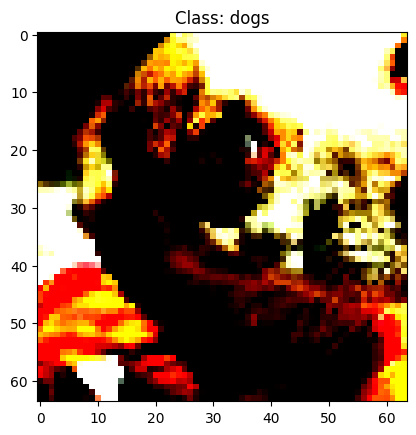

In [6]:
# Visualise sample transformed image

sample_image, sample_label = dataset[100]
plt.imshow(sample_image.permute(1, 2, 0))
plt.title(f"Class: {dataset.classes[sample_label]}")
plt.show()

## c. Dataset preparation:

In [7]:
input_size = (64, 3, 64, 64)
in_channels = 3
num_classes = 3
learning_rate = 0.001
batch_size = 64
num_epochs = 5

In [8]:
dataset_size = len(dataset)
train_size = int(0.7 * dataset_size)
val_size = int(0.15 * dataset_size)
test_size = dataset_size - train_size - val_size

# Split the dataset into train, validation, and test
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Create DataLoader
train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size = batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle=False)


# Stats
print(f"Train set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")
print(f"Test set size: {len(test_dataset)}")

Train set size: 21000
Validation set size: 4500
Test set size: 4500


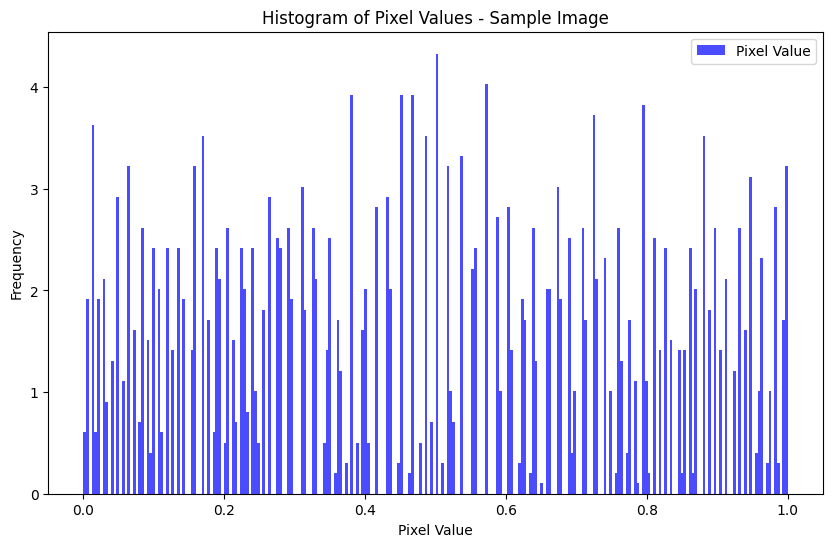

In [9]:
# Display histogram representation of the pixels
def plot_pixel_histogram(images, title):
    plt.figure(figsize=(10, 6))
    plt.hist(images.flatten(), bins=256, range=(0, 1), density=True, alpha=0.7, color='b', label='Pixel Value')
    plt.title(title)
    plt.xlabel('Pixel Value')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()


# Display histogram representation of pixel values
for images, _ in train_loader:
    plot_pixel_histogram(images[0].numpy(), 'Histogram of Pixel Values - Sample Image')
    break

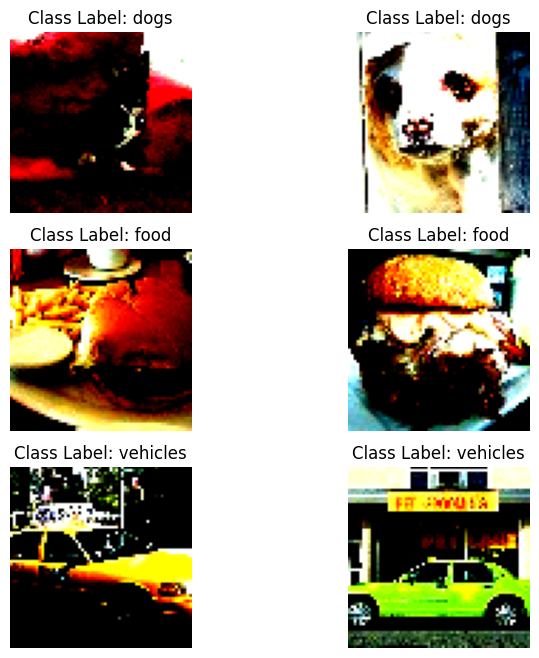

In [10]:
# Sample images for each category
def plot_sample_images(dataset, num_samples=2):
    fig, axes = plt.subplots(len(dataset.classes), num_samples, figsize=(8, 8))
    for i, class_name in enumerate(dataset.classes):
        class_indices = [index for index, label in enumerate(dataset.targets) if label == i]
        for j in range(num_samples):
            img, _ = dataset[class_indices[j]]
            axes[i, j].imshow(np.transpose(img, (1, 2, 0)))
            axes[i, j].set_title(f'Class Label: {class_name}')
            axes[i, j].axis('off')
    plt.show()

# Display sample images for each category
plot_sample_images(dataset, num_samples=2)

# **2. VGG 13 Model Architecture**

In [11]:
vgg13 = [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M']


In [12]:
class VGG(nn.Module):
  def __init__(self, in_channels=3, num_classes=3):
    super(VGG, self).__init__()
    self.in_channels = in_channels
    self.num_classes = num_classes
    self.conv_layers = self.conv_block(vgg13)
    self.fcn = nn.Sequential(
        nn.Linear(2048, 4096),
        nn.ReLU(),
        # nn.Dropout(p=0.5),

        nn.Linear(4096, 4096),
        nn.ReLU(),
        # nn.Dropout(p=0.5),

        nn.Linear(4096, num_classes),

    )

  def forward(self, x):
    x = self.conv_layers(x)
    # print(x.shape)
    x = x.reshape(x.shape[0], -1)
    # print(x.shape)
    x = self.fcn(x)
    return F.log_softmax(x, dim = 1)

  def conv_block(self, architecture):
    layers = []
    in_channels = self.in_channels
    for x in architecture:
      if type(x)==int:
        out_channels = x
        layers += [nn.Conv2d(in_channels = in_channels,
                             out_channels = out_channels,
                             kernel_size = (3,3),
                             stride = (1,1),
                             padding = (1,1)),

                   nn.BatchNorm2d(x),
                   nn.ReLU()]
        in_channels = x

      elif x == 'M':
        layers += [nn.MaxPool2d(kernel_size = (2,2), stride = (2,2))]

    return nn.Sequential(*layers)  # * unpacks the items of 'layers' and put them in sequential



# **Initialize Base Model**

In [13]:
cnn_base_model = VGG(in_channels = in_channels, num_classes = num_classes).to(device=device)

## **Loss & Optimizer**

In [14]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn_base_model.parameters(), lr = learning_rate)

## **3. Train Network**

In [15]:
for batch_idx, (image, label) in enumerate(train_loader):
  print(image.shape)
  break

torch.Size([64, 3, 64, 64])


In [16]:
cnn_base_model.train()

train_losses, train_accuracies = [], []
validation_losses, validation_accuracies = [], []
test_losses, test_accuracies = [], []

for epoch in range(num_epochs):

  correct_train = 0
  loss_total = 0

  for batch_idx, (train_image, train_label) in enumerate(train_loader):
    # if torch.cuda.is_available():
    train_image = train_image.to(device = device)
    train_label = train_label.to(device = device)

    # Forward Pass
    optimizer.zero_grad()
    train_prediction = cnn_base_model(train_image)
    training_loss = criterion(train_prediction, train_label)

    # Backward Pass
    training_loss.backward()

    # Gradient Descent
    optimizer.step()

    # Compute Loss

    loss_total += training_loss.item()

    _, predicted_label_train = torch.max(train_prediction.data, dim = 1)

    correct_train += (predicted_label_train == train_label).sum().item()

  LOSS = loss_total / train_size
  train_accuracy = correct_train / train_size

  train_losses.append(LOSS)
  train_accuracies.append(train_accuracy*100)

  print(f' Epoch {epoch+1} || Train Accuracy: {train_accuracy * 100:.3f} || Train Loss:{LOSS:.4f}' )


  # Validate the model:

  cnn_base_model.eval().to(device = device)

  with torch.no_grad():
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    for batch_idx, (inputs_val, labels_val) in enumerate(val_loader):
      inputs_val = inputs_val.to(device = device)
      labels_val = labels_val.to(device = device)

      outputs_val = cnn_base_model(inputs_val)

      val_loss = criterion(outputs_val, labels_val)
      val_loss += val_loss.item()

      _, predicted_label_val = torch.max(outputs_val.data, dim = 1)
      correct_val += (predicted_label_val == labels_val).sum().item()

    validation_loss = val_loss / len(val_loader)
    validation_accuracy = correct_val / val_size

    validation_losses.append(validation_loss.cpu().numpy())
    validation_accuracies.append(validation_accuracy*100)

    print(f'\t Validation Accuracy: {validation_accuracy * 100:.3f} || Validation Loss: {validation_loss:.3f}')

 Epoch 1 || Train Accuracy: 68.600 || Train Loss:0.0117
	 Validation Accuracy: 78.178 || Validation Loss: 0.017
 Epoch 2 || Train Accuracy: 83.990 || Train Loss:0.0069
	 Validation Accuracy: 82.133 || Validation Loss: 0.012
 Epoch 3 || Train Accuracy: 87.833 || Train Loss:0.0053
	 Validation Accuracy: 88.000 || Validation Loss: 0.003
 Epoch 4 || Train Accuracy: 88.424 || Train Loss:0.0050
	 Validation Accuracy: 88.956 || Validation Loss: 0.008
 Epoch 5 || Train Accuracy: 89.948 || Train Loss:0.0044
	 Validation Accuracy: 89.800 || Validation Loss: 0.005


In [17]:
cnn_base_model.eval()

test_loss = 0.0
correct_test = 0
total_test = 0

test_true_labels, test_predicted_labels = [], []

with torch.no_grad():
    for inputs_test, labels_test in test_loader:

        inputs_test, labels_test = inputs_test.to(device), labels_test.to(device)
        output_test = cnn_base_model(inputs_test)

        test_loss += criterion(output_test, labels_test).item()

        _, predicted_test_labels = torch.max(output_test.data, 1)
        total_test += labels_test.size(0)
        correct_test += (predicted_test_labels == labels_test).sum().item()

        test_predicted_labels.extend(predicted_test_labels.cpu().numpy())
        test_true_labels.extend(labels_test.cpu().numpy())

test_accuracy = correct_test / total_test
test_loss /= len(test_loader)

print(f'Test Accuracy: {test_accuracy*100:.3f}:')
print(f'Test Loss: {test_loss:.3f}')

Test Accuracy: 90.267:
Test Loss: 0.252


In [18]:
print(f"Training Accuracy: {train_accuracy*100:.4f}, Training Loss: {LOSS:.4f}")
print(f"Validation Accuracy: {validation_accuracy*100:.4f}, Validation Loss: {validation_loss:.4f}")
print(f"Testing Accuracy: {test_accuracy*100:.4f}, Testing Loss: {test_loss:.4f}")

Training Accuracy: 89.9476, Training Loss: 0.0044
Validation Accuracy: 89.8000, Validation Loss: 0.0048
Testing Accuracy: 90.2667, Testing Loss: 0.2524


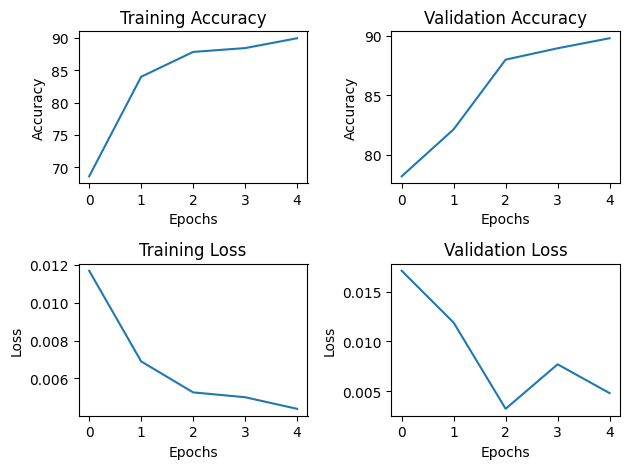

In [19]:
# Plot Training and Validation Accuracy over time (epoch)
plt.figure()
plt.subplot(2, 2, 1)
plt.plot(train_accuracies, label='Training Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.subplot(2, 2, 2)
plt.plot(validation_accuracies, label='Validation Accuracy')
plt.title('Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')


# Plot Training and Validation Loss over time (epoch)
plt.subplot(2, 2, 3)
plt.plot(train_losses, label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.subplot(2, 2, 4)
plt.plot(validation_losses, label='Validation Loss')
plt.title('Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.tight_layout()
plt.show()

In [20]:
# Evaluation
accuracy_test = accuracy_score(test_predicted_labels, test_true_labels) * 100
precision_test = precision_score(test_predicted_labels, test_true_labels, average='micro')
recall_test = recall_score(test_predicted_labels, test_true_labels, average='macro')
f1_test = f1_score(test_predicted_labels, test_true_labels, average='macro')
confusion_matrix_test = confusion_matrix(test_predicted_labels, test_true_labels)

print(f'Accuracy: {accuracy_test:.3f}')
print(f'Precision: {precision_test:.3f}')
print(f'Recall: {recall_test:.3f}')
print(f'F1 score: {f1_test:.3f}')
print('\nConfusion Matrix: \n', confusion_matrix_test)

Accuracy: 90.267
Precision: 0.903
Recall: 0.905
F1 score: 0.902

Confusion Matrix: 
 [[1357  177   51]
 [  66 1240    8]
 [  60   76 1465]]


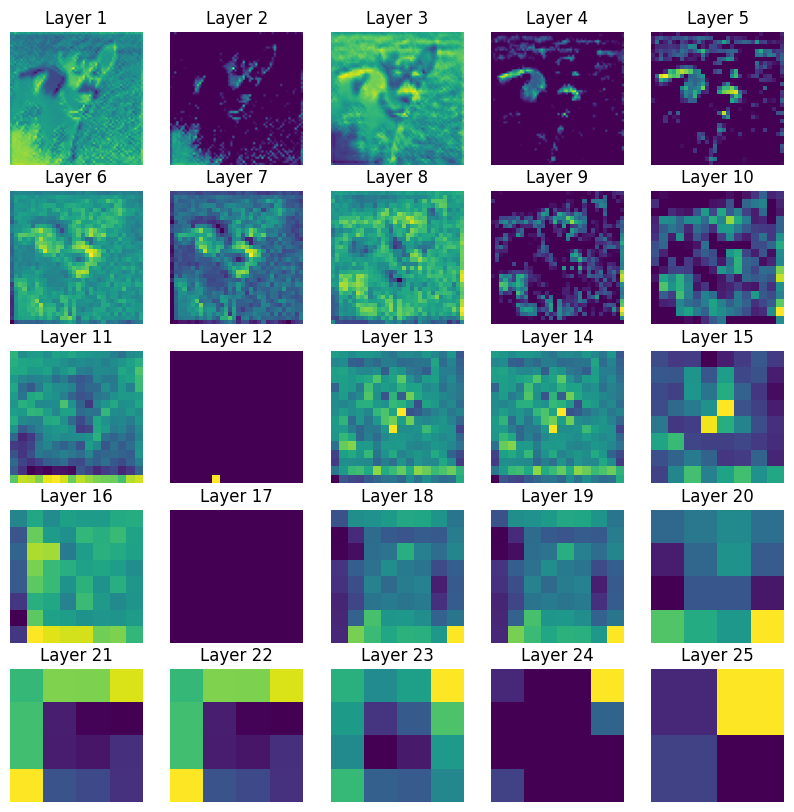

In [27]:
# Feature Map of the model

cnn_base_model = VGG(in_channels = in_channels, num_classes = num_classes).to(device=device)

# Choose layers for feature extraction
req_layers = ['Conv2d', 'ReLU', 'MaxPool2d']
feature_layers = []

# Function to get feature maps from a single image
def get_feature_maps(image, cnn_base_model, layers):
    feature_maps = []
    for layer in layers:
        image = layer(image)
        feature_maps.append(image)
    return feature_maps

# Populate feature_layers based on layer names
for layer in cnn_base_model.conv_layers.children():
    if any(req_layer in layer.__class__.__name__ for req_layer in req_layers):
        feature_layers.append(layer)

# Set the model to evaluation mode
cnn_base_model.eval()

# Get a single batch from the DataLoader
for images, labels in train_loader:
    sample_image = images.to(device)
    break  # Break after the first batch

# Get feature maps
with torch.no_grad():
    feature_maps = get_feature_maps(sample_image, cnn_base_model.conv_layers, feature_layers)

# Plot the feature maps in a subplot
num_layers = len(feature_maps)
num_cols = 5
num_rows = math.ceil(num_layers / num_cols)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 10))

for i in range(num_layers):
    row, col = i // num_cols, i % num_cols
    axes[row, col].imshow(feature_maps[i][0, 0].cpu().numpy(), cmap='viridis')
    axes[row, col].set_title(f"Layer {i+1}")
    axes[row, col].axis('off')

plt.show()

# **Applying Regularization**

In [ ]:
cnn_base_reg_model = VGG(in_channels = in_channels, num_classes = num_classes).to(device=device)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn_base_reg_model.parameters(), lr = learning_rate, weight_decay=1e-5)

In [ ]:
cnn_base_reg_model.train()

train_losses, train_accuracies = [], []
validation_losses, validation_accuracies = [], []
test_losses, test_accuracies = [], []

for epoch in range(num_epochs):

  correct_train = 0
  loss_total = 0

  for batch_idx, (train_image, train_label) in enumerate(train_loader):
    # if torch.cuda.is_available():
    train_image = train_image.to(device = device)
    train_label = train_label.to(device = device)

    # Forward Pass
    optimizer.zero_grad()
    train_prediction = cnn_base_reg_model(train_image)
    training_loss = criterion(train_prediction, train_label)

    # Backward Pass
    training_loss.backward()

    # Gradient Descent
    optimizer.step()

    # Compute Loss

    loss_total += training_loss.item()

    _, predicted_label_train = torch.max(train_prediction.data, dim = 1)

    correct_train += (predicted_label_train == train_label).sum().item()

  LOSS = loss_total / train_size
  train_accuracy = correct_train / train_size

  train_losses.append(LOSS)
  train_accuracies.append(train_accuracy*100)

  print(f' Epoch {epoch+1} || Train Accuracy: {train_accuracy * 100:.3f} || Train Loss:{LOSS:.4f}' )


  # Validate the model:

  cnn_base_model.eval().to(device = device)

  with torch.no_grad():
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    for batch_idx, (inputs_val, labels_val) in enumerate(val_loader):
      inputs_val = inputs_val.to(device = device)
      labels_val = labels_val.to(device = device)

      outputs_val = cnn_base_reg_model(inputs_val)

      val_loss = criterion(outputs_val, labels_val)
      val_loss += val_loss.item()

      _, predicted_label_val = torch.max(outputs_val.data, dim = 1)
      correct_val += (predicted_label_val == labels_val).sum().item()

    validation_loss = val_loss / len(val_loader)
    validation_accuracy = correct_val / val_size

    validation_losses.append(validation_loss.cpu().numpy())
    validation_accuracies.append(validation_accuracy*100)

    print(f'\t Validation Accuracy: {validation_accuracy * 100:.3f} || Validation Loss: {validation_loss:.3f}')

 Epoch 1 || Train Accuracy: 72.581 || Train Loss:0.0105
	 Validation Accuracy: 85.511 || Validation Loss: 0.005
 Epoch 2 || Train Accuracy: 87.686 || Train Loss:0.0055
	 Validation Accuracy: 87.644 || Validation Loss: 0.005
 Epoch 3 || Train Accuracy: 89.629 || Train Loss:0.0045
	 Validation Accuracy: 87.978 || Validation Loss: 0.008
 Epoch 4 || Train Accuracy: 90.286 || Train Loss:0.0041
	 Validation Accuracy: 90.578 || Validation Loss: 0.006
 Epoch 5 || Train Accuracy: 91.733 || Train Loss:0.0036
	 Validation Accuracy: 91.956 || Validation Loss: 0.008


In [ ]:
cnn_base_reg_model.eval()

test_loss = 0.0
correct_test = 0
total_test = 0

test_true_labels, test_predicted_labels = [], []

with torch.no_grad():
    for inputs_test, labels_test in test_loader:

        inputs_test, labels_test = inputs_test.to(device), labels_test.to(device)
        output_test = cnn_base_reg_model(inputs_test)

        test_loss += criterion(output_test, labels_test).item()

        _, predicted_test_labels = torch.max(output_test.data, 1)
        total_test += labels_test.size(0)
        correct_test += (predicted_test_labels == labels_test).sum().item()

        test_predicted_labels.extend(predicted_test_labels.cpu().numpy())
        test_true_labels.extend(labels_test.cpu().numpy())

test_accuracy = correct_test / total_test
test_loss /= len(test_loader)

print(f'Test Accuracy: {test_accuracy*100:.3f}:')
print(f'Test Loss: {test_loss:.3f}')

Test Accuracy: 92.000:
Test Loss: 0.222


In [ ]:
print(f"Training Accuracy: {train_accuracy*100:.4f}, Training Loss: {LOSS:.4f}")
print(f"Validation Accuracy: {validation_accuracy*100:.4f}, Validation Loss: {validation_loss:.4f}")
print(f"Testing Accuracy: {test_accuracy*100:.4f}, Testing Loss: {test_loss:.4f}")

Training Accuracy: 91.7333, Training Loss: 0.0036
Validation Accuracy: 91.9556, Validation Loss: 0.0075
Testing Accuracy: 92.0000, Testing Loss: 0.2216


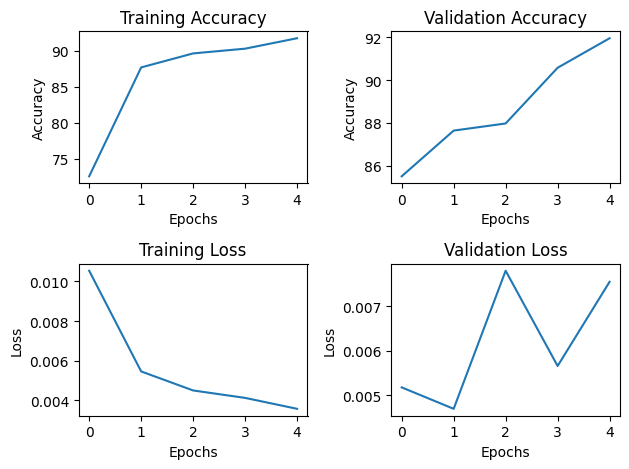

In [ ]:
# Plot Training and Validation Accuracy over time (epoch)
plt.figure()
plt.subplot(2, 2, 1)
plt.plot(train_accuracies, label='Training Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.subplot(2, 2, 2)
plt.plot(validation_accuracies, label='Validation Accuracy')
plt.title('Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')


# Plot Training and Validation Loss over time (epoch)
plt.subplot(2, 2, 3)
plt.plot(train_losses, label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.subplot(2, 2, 4)
plt.plot(validation_losses, label='Validation Loss')
plt.title('Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.tight_layout()
plt.show()

In [ ]:
# Evaluation
accuracy_test = accuracy_score(test_predicted_labels, test_true_labels) * 100
precision_test = precision_score(test_predicted_labels, test_true_labels, average='micro')
recall_test = recall_score(test_predicted_labels, test_true_labels, average='macro')
f1_test = f1_score(test_predicted_labels, test_true_labels, average='macro')
confusion_matrix_test = confusion_matrix(test_predicted_labels, test_true_labels)

print(f'Accuracy: {accuracy_test:.3f}')
print(f'Precision: {precision_test:.3f}')
print(f'Recall: {recall_test:.3f}')
print(f'F1 score: {f1_test:.3f}')
print('\nConfusion Matrix: \n', confusion_matrix_test)

Accuracy: 92.000
Precision: 0.920
Recall: 0.921
F1 score: 0.920

Confusion Matrix: 
 [[1393  120   54]
 [  71 1327   53]
 [  38   24 1420]]


# **Dropout Layers between Fully Connected Layers**

In [ ]:
class VGG_Improved(nn.Module):
  def __init__(self, in_channels=3, num_classes=3):
    super(VGG_Improved, self).__init__()
    self.in_channels = in_channels
    self.num_classes = num_classes
    self.conv_layers = self.conv_block(vgg13) #Convolution returns image of dim: 7*7*512
    self.fcn = nn.Sequential(
        nn.Linear(2048, 4096),
        nn.ReLU(),
        nn.Dropout(p=0.5),

        nn.Linear(4096, 4096),
        nn.ReLU(),
        nn.Dropout(p=0.5),

        nn.Linear(4096, num_classes),

    )

  def forward(self, x):
    x = self.conv_layers(x)
    x = x.reshape(x.shape[0], -1)
    x = self.fcn(x)
    return F.log_softmax(x, dim = 1)

  def conv_block(self, architecture):
    layers = []
    in_channels = self.in_channels
    for x in architecture:
      if type(x)==int:
        out_channels = x
        layers += [nn.Conv2d(in_channels = in_channels,
                             out_channels = out_channels,
                             kernel_size = (3,3),
                             stride = (1,1),
                             padding = (1,1)),

                   nn.BatchNorm2d(x),
                   nn.ReLU()]
        in_channels = x

      elif x == 'M':
        layers += [nn.MaxPool2d(kernel_size = (2,2), stride = (2,2))]

    return nn.Sequential(*layers)  # * unpacks the items of 'layers' and put them in sequential



In [ ]:
cnn_base_reg_dropout_model = VGG_Improved(in_channels = in_channels, num_classes = num_classes).to(device=device)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn_base_reg_dropout_model.parameters(), lr = learning_rate, weight_decay=1e-5)

In [ ]:
cnn_base_reg_dropout_model.train()

train_losses, train_accuracies = [], []
validation_losses, validation_accuracies = [], []
test_losses, test_accuracies = [], []

for epoch in range(num_epochs):

  correct_train = 0
  loss_total = 0

  for batch_idx, (train_image, train_label) in enumerate(train_loader):
    # if torch.cuda.is_available():
    train_image = train_image.to(device = device)
    train_label = train_label.to(device = device)

    # Forward Pass
    optimizer.zero_grad()
    train_prediction = cnn_base_reg_dropout_model(train_image)
    training_loss = criterion(train_prediction, train_label)

    # Backward Pass
    training_loss.backward()

    # Gradient Descent
    optimizer.step()

    # Compute Loss

    loss_total += training_loss.item()

    _, predicted_label_train = torch.max(train_prediction.data, dim = 1)

    correct_train += (predicted_label_train == train_label).sum().item()

  LOSS = loss_total / train_size
  train_accuracy = correct_train / train_size

  train_losses.append(LOSS)
  train_accuracies.append(train_accuracy*100)

  print(f' Epoch {epoch+1} || Train Accuracy: {train_accuracy * 100:.3f} || Train Loss:{LOSS:.4f}' )


  # Validate the model:

  cnn_base_reg_dropout_model.eval().to(device = device)

  with torch.no_grad():
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    for batch_idx, (inputs_val, labels_val) in enumerate(val_loader):
      inputs_val = inputs_val.to(device = device)
      labels_val = labels_val.to(device = device)

      outputs_val = cnn_base_reg_dropout_model(inputs_val)

      val_loss = criterion(outputs_val, labels_val)
      val_loss += val_loss.item()

      _, predicted_label_val = torch.max(outputs_val.data, dim = 1)
      correct_val += (predicted_label_val == labels_val).sum().item()

    validation_loss = val_loss / len(val_loader)
    validation_accuracy = correct_val / val_size

    validation_losses.append(validation_loss.cpu().numpy())
    validation_accuracies.append(validation_accuracy*100)

    print(f'\t Validation Accuracy: {validation_accuracy * 100:.3f} || Validation Loss: {validation_loss:.3f}')

 Epoch 1 || Train Accuracy: 69.176 || Train Loss:0.0118
	 Validation Accuracy: 83.089 || Validation Loss: 0.009
 Epoch 2 || Train Accuracy: 82.486 || Train Loss:0.0072
	 Validation Accuracy: 83.911 || Validation Loss: 0.008
 Epoch 3 || Train Accuracy: 86.810 || Train Loss:0.0055
	 Validation Accuracy: 87.733 || Validation Loss: 0.002
 Epoch 4 || Train Accuracy: 88.310 || Train Loss:0.0050
	 Validation Accuracy: 89.956 || Validation Loss: 0.004
 Epoch 5 || Train Accuracy: 89.848 || Train Loss:0.0045
	 Validation Accuracy: 90.689 || Validation Loss: 0.006


In [ ]:
cnn_base_reg_dropout_model.eval()

test_loss = 0.0
correct_test = 0
total_test = 0

test_true_labels, test_predicted_labels = [], []

with torch.no_grad():
    for inputs_test, labels_test in test_loader:

        inputs_test, labels_test = inputs_test.to(device), labels_test.to(device)
        output_test = cnn_base_reg_dropout_model(inputs_test)

        test_loss += criterion(output_test, labels_test).item()

        _, predicted_test_labels = torch.max(output_test.data, 1)
        total_test += labels_test.size(0)
        correct_test += (predicted_test_labels == labels_test).sum().item()

        test_predicted_labels.extend(predicted_test_labels.cpu().numpy())
        test_true_labels.extend(labels_test.cpu().numpy())

test_accuracy = correct_test / total_test
test_loss /= len(test_loader)

print(f'Test Accuracy: {test_accuracy*100:.3f}:')
print(f'Test Loss: {test_loss:.3f}')

Test Accuracy: 90.844:
Test Loss: 0.261


In [ ]:
print(f"Training Accuracy: {train_accuracy*100:.4f}, Training Loss: {LOSS:.4f}")
print(f"Validation Accuracy: {validation_accuracy*100:.4f}, Validation Loss: {validation_loss:.4f}")
print(f"Testing Accuracy: {test_accuracy*100:.4f}, Testing Loss: {test_loss:.4f}")

Training Accuracy: 89.8476, Training Loss: 0.0045
Validation Accuracy: 90.6889, Validation Loss: 0.0063
Testing Accuracy: 90.8444, Testing Loss: 0.2608


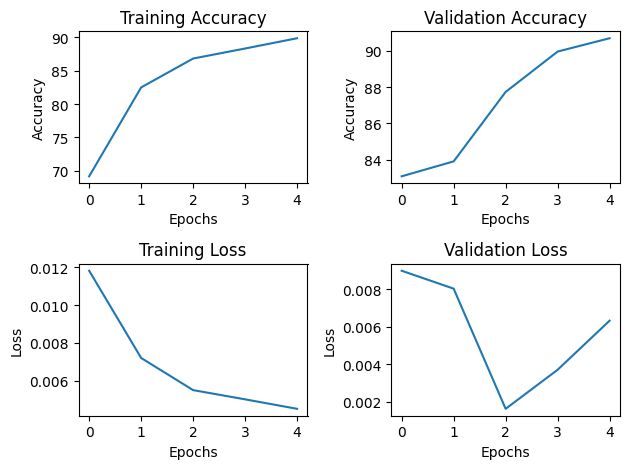

In [ ]:
# Plot Training and Validation Accuracy over time (epoch)
plt.figure()
plt.subplot(2, 2, 1)
plt.plot(train_accuracies, label='Training Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.subplot(2, 2, 2)
plt.plot(validation_accuracies, label='Validation Accuracy')
plt.title('Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')


# Plot Training and Validation Loss over time (epoch)
plt.subplot(2, 2, 3)
plt.plot(train_losses, label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.subplot(2, 2, 4)
plt.plot(validation_losses, label='Validation Loss')
plt.title('Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.tight_layout()
plt.show()

In [ ]:
# Evaluation
accuracy_test = accuracy_score(test_predicted_labels, test_true_labels) * 100
precision_test = precision_score(test_predicted_labels, test_true_labels, average='micro')
recall_test = recall_score(test_predicted_labels, test_true_labels, average='macro')
f1_test = f1_score(test_predicted_labels, test_true_labels, average='macro')
confusion_matrix_test = confusion_matrix(test_predicted_labels, test_true_labels)

print(f'Accuracy: {accuracy_test:.3f}')
print(f'Precision: {precision_test:.3f}')
print(f'Recall: {recall_test:.3f}')
print(f'F1 score: {f1_test:.3f}')
print('\nConfusion Matrix: \n', confusion_matrix_test)

Accuracy: 90.844
Precision: 0.908
Recall: 0.910
F1 score: 0.909

Confusion Matrix: 
 [[1314   80   57]
 [ 154 1373   69]
 [  34   18 1401]]


# **Early Stopping**

In [ ]:
cnn_base_reg_dropout_earlystop_model = VGG_Improved(in_channels = in_channels, num_classes = num_classes).to(device=device)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn_base_reg_dropout_earlystop_model.parameters(), lr = learning_rate, weight_decay=1e-5)
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [ ]:
cnn_base_reg_dropout_earlystop_model.train()

train_losses, train_accuracies = [], []
validation_losses, validation_accuracies = [], []
test_losses, test_accuracies = [], []

num_epochs = 20

val_loss_flag = float('inf')
patience = 4
counter = 0

for epoch in range(num_epochs):

  correct_train = 0
  loss_total = 0

  for batch_idx, (train_image, train_label) in enumerate(train_loader):
    # if torch.cuda.is_available():
    train_image = train_image.to(device = device)
    train_label = train_label.to(device = device)

    # Forward Pass
    optimizer.zero_grad()
    train_prediction = cnn_base_reg_dropout_earlystop_model(train_image)
    training_loss = criterion(train_prediction, train_label)

    # Backward Pass
    training_loss.backward()

    # Gradient Descent
    optimizer.step()

    # Compute Loss

    loss_total += training_loss.item()

    _, predicted_label_train = torch.max(train_prediction.data, dim = 1)

    correct_train += (predicted_label_train == train_label).sum().item()

  LOSS = loss_total / train_size
  train_accuracy = correct_train / train_size

  train_losses.append(LOSS)
  train_accuracies.append(train_accuracy*100)

  print(f' Epoch {epoch+1} || Train Accuracy: {train_accuracy * 100:.3f} || Train Loss:{LOSS:.4f}' )


  # Validate the model:

  cnn_base_reg_dropout_earlystop_model.eval().to(device = device)

  with torch.no_grad():
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    for batch_idx, (inputs_val, labels_val) in enumerate(val_loader):
      inputs_val = inputs_val.to(device = device)
      labels_val = labels_val.to(device = device)

      outputs_val = cnn_base_reg_dropout_earlystop_model(inputs_val)

      val_loss = criterion(outputs_val, labels_val)
      val_loss += val_loss.item()

      _, predicted_label_val = torch.max(outputs_val.data, dim = 1)
      correct_val += (predicted_label_val == labels_val).sum().item()

    validation_loss = val_loss / len(val_loader)
    validation_accuracy = correct_val / val_size

    validation_losses.append(validation_loss.cpu().numpy())
    validation_accuracies.append(validation_accuracy*100)

    print(f'\t Validation Accuracy: {validation_accuracy * 100:.3f} || Validation Loss: {validation_loss:.4f}')

    scheduler.step()

  if validation_loss < val_loss_flag:
    val_loss_flag = validation_loss
    torch.save(cnn_base_reg_dropout_earlystop_model.state_dict(), "shivanma_debosmit_assignment1_part_1.pth")
    counter = 0
  else:
    counter += 1
    if counter >= patience:
      print(f"\n Early Stopping at epoch {epoch+1}")
      break

 Epoch 1 || Train Accuracy: 70.871 || Train Loss:0.0112
	 Validation Accuracy: 81.267 || Validation Loss: 0.0125
 Epoch 2 || Train Accuracy: 73.233 || Train Loss:0.0099
	 Validation Accuracy: 83.422 || Validation Loss: 0.0064
 Epoch 3 || Train Accuracy: 84.567 || Train Loss:0.0064
	 Validation Accuracy: 85.889 || Validation Loss: 0.0065
 Epoch 4 || Train Accuracy: 86.957 || Train Loss:0.0055
	 Validation Accuracy: 88.289 || Validation Loss: 0.0060
 Epoch 5 || Train Accuracy: 88.357 || Train Loss:0.0048
	 Validation Accuracy: 86.333 || Validation Loss: 0.0098
 Epoch 6 || Train Accuracy: 89.190 || Train Loss:0.0046
	 Validation Accuracy: 90.911 || Validation Loss: 0.0034
 Epoch 7 || Train Accuracy: 90.295 || Train Loss:0.0042
	 Validation Accuracy: 88.711 || Validation Loss: 0.0068
 Epoch 8 || Train Accuracy: 92.281 || Train Loss:0.0033
	 Validation Accuracy: 92.022 || Validation Loss: 0.0030
 Epoch 9 || Train Accuracy: 92.724 || Train Loss:0.0031
	 Validation Accuracy: 92.311 || Validat

In [ ]:
cnn_base_reg_dropout_earlystop_model.eval()

test_loss = 0.0
correct_test = 0
total_test = 0

test_true_labels, test_predicted_labels = [], []

with torch.no_grad():
    for inputs_test, labels_test in test_loader:

        inputs_test, labels_test = inputs_test.to(device), labels_test.to(device)
        output_test = cnn_base_reg_dropout_earlystop_model(inputs_test)

        test_loss += criterion(output_test, labels_test).item()

        _, predicted_test_labels = torch.max(output_test.data, 1)
        total_test += labels_test.size(0)
        correct_test += (predicted_test_labels == labels_test).sum().item()

        test_predicted_labels.extend(predicted_test_labels.cpu().numpy())
        test_true_labels.extend(labels_test.cpu().numpy())

test_accuracy = correct_test / total_test
test_loss /= len(test_loader)

print(f'Test Accuracy: {test_accuracy*100:.3f}:')
print(f'Test Loss: {test_loss:.3f}')

Test Accuracy: 93.022:
Test Loss: 0.199


In [ ]:
print(f"Training Accuracy: {train_accuracy*100:.4f}, Training Loss: {LOSS:.4f}")
print(f"Validation Accuracy: {validation_accuracy*100:.4f}, Validation Loss: {validation_loss:.4f}")
print(f"Testing Accuracy: {test_accuracy*100:.4f}, Testing Loss: {test_loss:.4f}")

Training Accuracy: 94.3333, Training Loss: 0.0024
Validation Accuracy: 92.8444, Validation Loss: 0.0019
Testing Accuracy: 93.0222, Testing Loss: 0.1995


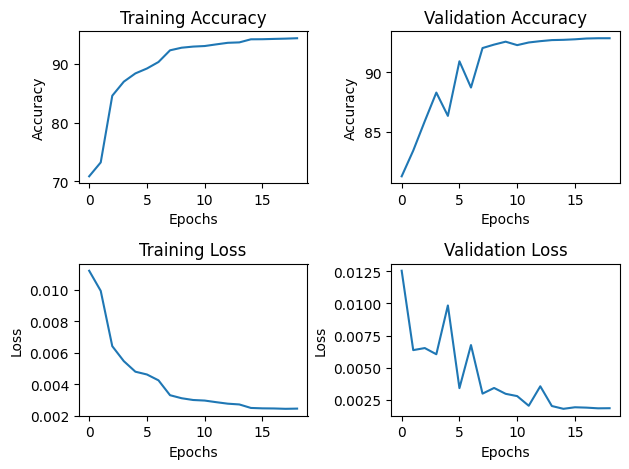

In [ ]:
# Plot Training and Validation Accuracy over time (epoch)
plt.figure()
plt.subplot(2, 2, 1)
plt.plot(train_accuracies, label='Training Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.subplot(2, 2, 2)
plt.plot(validation_accuracies, label='Validation Accuracy')
plt.title('Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')


# Plot Training and Validation Loss over time (epoch)
plt.subplot(2, 2, 3)
plt.plot(train_losses, label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.subplot(2, 2, 4)
plt.plot(validation_losses, label='Validation Loss')
plt.title('Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.tight_layout()
plt.show()

In [ ]:
# Evaluation
accuracy_test = accuracy_score(test_predicted_labels, test_true_labels) * 100
precision_test = precision_score(test_predicted_labels, test_true_labels, average='micro')
recall_test = recall_score(test_predicted_labels, test_true_labels, average='macro')
f1_test = f1_score(test_predicted_labels, test_true_labels, average='macro')
confusion_matrix_test = confusion_matrix(test_predicted_labels, test_true_labels)

print(f'Accuracy: {accuracy_test:.3f}')
print(f'Precision: {precision_test:.3f}')
print(f'Recall: {recall_test:.3f}')
print(f'F1 score: {f1_test:.3f}')
print('\nConfusion Matrix: \n', confusion_matrix_test)

Accuracy: 93.022
Precision: 0.930
Recall: 0.931
F1 score: 0.930

Confusion Matrix: 
 [[1398  102   53]
 [  59 1342   28]
 [  45   27 1446]]


# **Image Augmentation**

In [ ]:
from torchvision.transforms import v2

image_augmentation = v2.Compose([
    v2.RandomResizedCrop(size=(64, 64), antialias=True),
    v2.RandomHorizontalFlip(p=0.5),
    v2.ToDtype(torch.float32, scale=True),
    transforms.ToTensor(),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

dataset_2 = datasets.ImageFolder(root=root_dir, transform=image_augmentation)

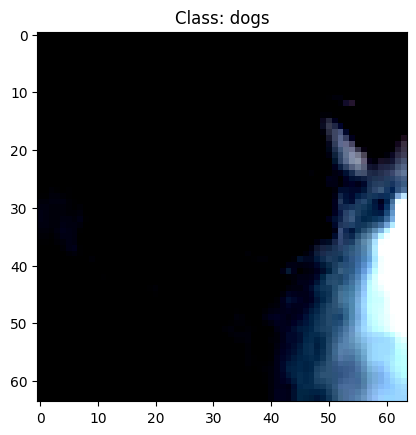

In [ ]:
sample_image, sample_label = dataset_2[1000]
plt.imshow(sample_image.permute(1, 2, 0))
plt.title(f"Class: {dataset_2.classes[sample_label]}")
plt.show()

In [ ]:
dataset_2_size = len(dataset_2)
train_size = int(0.7 * dataset_2_size)
val_size = int(0.15 * dataset_2_size)
test_size = dataset_2_size - train_size - val_size

# Split the dataset into train, validation, and test
train_dataset_2, val_dataset_2, test_dataset_2 = random_split(dataset_2, [train_size, val_size, test_size])

# Create DataLoader
train_loader_2 = DataLoader(train_dataset_2, batch_size = batch_size, shuffle=True)
val_loader_2 = DataLoader(val_dataset_2, batch_size = batch_size, shuffle=False)
test_loader_2 = DataLoader(test_dataset_2, batch_size = batch_size, shuffle=False)

In [ ]:
cnn_base_reg_dropout_earlystop_imageaug_model = VGG_Improved(in_channels = in_channels, num_classes = num_classes).to(device=device)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn_base_reg_dropout_earlystop_imageaug_model.parameters(), lr = learning_rate, weight_decay=1e-5)
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [ ]:
cnn_base_reg_dropout_earlystop_imageaug_model.train()

train_losses, train_accuracies = [], []
validation_losses, validation_accuracies = [], []
test_losses, test_accuracies = [], []

num_epochs = 20

val_loss_flag = float('inf')
patience = 4
counter = 0

for epoch in range(num_epochs):

  correct_train = 0
  loss_total = 0

  for batch_idx, (train_image, train_label) in enumerate(train_loader_2):
    # if torch.cuda.is_available():
    train_image = train_image.to(device = device)
    train_label = train_label.to(device = device)

    # Forward Pass
    optimizer.zero_grad()
    train_prediction = cnn_base_reg_dropout_earlystop_imageaug_model(train_image)
    training_loss = criterion(train_prediction, train_label)

    # Backward Pass
    training_loss.backward()

    # Gradient Descent
    optimizer.step()

    # Compute Loss

    loss_total += training_loss.item()

    _, predicted_label_train = torch.max(train_prediction.data, dim = 1)

    correct_train += (predicted_label_train == train_label).sum().item()

  LOSS = loss_total / train_size
  train_accuracy = correct_train / train_size

  train_losses.append(LOSS)
  train_accuracies.append(train_accuracy*100)

  print(f' Epoch {epoch+1} || Train Accuracy: {train_accuracy * 100:.3f} || Train Loss:{LOSS:.4f}' )


  # Validate the model:

  cnn_base_reg_dropout_earlystop_imageaug_model.eval().to(device = device)

  with torch.no_grad():
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    for batch_idx, (inputs_val, labels_val) in enumerate(val_loader_2):
      inputs_val = inputs_val.to(device = device)
      labels_val = labels_val.to(device = device)

      outputs_val = cnn_base_reg_dropout_earlystop_imageaug_model(inputs_val)

      val_loss = criterion(outputs_val, labels_val)
      val_loss += val_loss.item()

      _, predicted_label_val = torch.max(outputs_val.data, dim = 1)
      correct_val += (predicted_label_val == labels_val).sum().item()

    validation_loss = val_loss / len(val_loader)
    validation_accuracy = correct_val / val_size

    validation_losses.append(validation_loss.cpu().numpy())
    validation_accuracies.append(validation_accuracy*100)

    print(f'\t Validation Accuracy: {validation_accuracy * 100:.3f} || Validation Loss: {validation_loss:.4f}')

    scheduler.step()

  if validation_loss < val_loss_flag:
    val_loss_flag = validation_loss
    torch.save(cnn_base_reg_dropout_earlystop_imageaug_model.state_dict(), "shivanma_debosmit_assignment1_part_1_imgaug.pth")
    counter = 0
  else:
    counter += 1
    if counter >= patience:
      print(f"\n Early Stopping at epoch {epoch+1}")
      break

 Epoch 1 || Train Accuracy: 64.495 || Train Loss:0.0132
	 Validation Accuracy: 68.622 || Validation Loss: 0.0149
 Epoch 2 || Train Accuracy: 67.629 || Train Loss:0.0116
	 Validation Accuracy: 72.422 || Validation Loss: 0.0173
 Epoch 3 || Train Accuracy: 77.843 || Train Loss:0.0087
	 Validation Accuracy: 77.356 || Validation Loss: 0.0169
 Epoch 4 || Train Accuracy: 81.281 || Train Loss:0.0076
	 Validation Accuracy: 82.689 || Validation Loss: 0.0090
 Epoch 5 || Train Accuracy: 82.710 || Train Loss:0.0070
	 Validation Accuracy: 81.089 || Validation Loss: 0.0067
 Epoch 6 || Train Accuracy: 83.424 || Train Loss:0.0068
	 Validation Accuracy: 85.089 || Validation Loss: 0.0086
 Epoch 7 || Train Accuracy: 84.295 || Train Loss:0.0064
	 Validation Accuracy: 85.067 || Validation Loss: 0.0103
 Epoch 8 || Train Accuracy: 86.476 || Train Loss:0.0056
	 Validation Accuracy: 86.467 || Validation Loss: 0.0084
 Epoch 9 || Train Accuracy: 86.938 || Train Loss:0.0054
	 Validation Accuracy: 87.578 || Validat

In [ ]:
cnn_base_reg_dropout_earlystop_imageaug_model.eval()

test_loss = 0.0
correct_test = 0
total_test = 0

test_true_labels, test_predicted_labels = [], []

with torch.no_grad():
    for inputs_test, labels_test in test_loader_2:

        inputs_test, labels_test = inputs_test.to(device), labels_test.to(device)
        output_test = cnn_base_reg_dropout_earlystop_imageaug_model(inputs_test)

        test_loss += criterion(output_test, labels_test).item()

        _, predicted_test_labels = torch.max(output_test.data, 1)
        total_test += labels_test.size(0)
        correct_test += (predicted_test_labels == labels_test).sum().item()

        test_predicted_labels.extend(predicted_test_labels.cpu().numpy())
        test_true_labels.extend(labels_test.cpu().numpy())

test_accuracy = correct_test / total_test
test_loss /= len(test_loader)

print(f'Test Accuracy: {test_accuracy*100:.3f}:')
print(f'Test Loss: {test_loss:.3f}')

Test Accuracy: 87.467:
Test Loss: 0.342


In [ ]:
print(f"Training Accuracy: {train_accuracy*100:.4f}, Training Loss: {LOSS:.4f}")
print(f"Validation Accuracy: {validation_accuracy*100:.4f}, Validation Loss: {validation_loss:.4f}")
print(f"Testing Accuracy: {test_accuracy*100:.4f}, Testing Loss: {test_loss:.4f}")

Training Accuracy: 87.7952, Training Loss: 0.0050
Validation Accuracy: 87.1333, Validation Loss: 0.0069
Testing Accuracy: 87.4667, Testing Loss: 0.3422


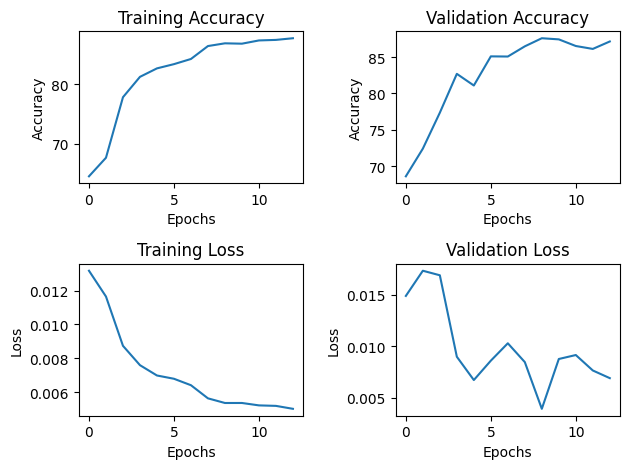

In [ ]:
# Plot Training and Validation Accuracy over time (epoch)
plt.figure()
plt.subplot(2, 2, 1)
plt.plot(train_accuracies, label='Training Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.subplot(2, 2, 2)
plt.plot(validation_accuracies, label='Validation Accuracy')
plt.title('Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')


# Plot Training and Validation Loss over time (epoch)
plt.subplot(2, 2, 3)
plt.plot(train_losses, label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.subplot(2, 2, 4)
plt.plot(validation_losses, label='Validation Loss')
plt.title('Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.tight_layout()
plt.show()

In [ ]:
# Evaluation
accuracy_test = accuracy_score(test_predicted_labels, test_true_labels) * 100
precision_test = precision_score(test_predicted_labels, test_true_labels, average='micro')
recall_test = recall_score(test_predicted_labels, test_true_labels, average='macro')
f1_test = f1_score(test_predicted_labels, test_true_labels, average='macro')
confusion_matrix_test = confusion_matrix(test_predicted_labels, test_true_labels)

print(f'Accuracy: {accuracy_test:.3f}')
print(f'Precision: {precision_test:.3f}')
print(f'Recall: {recall_test:.3f}')
print(f'F1 score: {f1_test:.3f}')
print('\nConfusion Matrix: \n', confusion_matrix_test)

Accuracy: 87.467
Precision: 0.875
Recall: 0.875
F1 score: 0.875

Confusion Matrix: 
 [[1331  168   81]
 [ 111 1225   48]
 [  95   61 1380]]


## Part II: ResNet

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision
from torch.utils.data import DataLoader, random_split
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
import time
import os
import tqdm
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
folder_path = '/content/drive/My Drive/cnn_dataset.zip'
!unzip '/content/drive/My Drive/cnn_dataset.zip' -d cnn_dataset

Streaming output truncated to the last 5000 lines.
  inflating: cnn_dataset/vehicles/5499.jpg  
  inflating: cnn_dataset/vehicles/55.jpg  
  inflating: cnn_dataset/vehicles/550.jpg  
  inflating: cnn_dataset/vehicles/5500.jpg  
  inflating: cnn_dataset/vehicles/5501.jpg  
  inflating: cnn_dataset/vehicles/5502.jpg  
  inflating: cnn_dataset/vehicles/5503.jpg  
  inflating: cnn_dataset/vehicles/5504.jpg  
  inflating: cnn_dataset/vehicles/5505.jpg  
  inflating: cnn_dataset/vehicles/5506.jpg  
  inflating: cnn_dataset/vehicles/5507.jpg  
  inflating: cnn_dataset/vehicles/5508.jpg  
  inflating: cnn_dataset/vehicles/5509.jpg  
  inflating: cnn_dataset/vehicles/551.jpg  
  inflating: cnn_dataset/vehicles/5510.jpg  
  inflating: cnn_dataset/vehicles/5511.jpg  
  inflating: cnn_dataset/vehicles/5512.jpg  
  inflating: cnn_dataset/vehicles/5513.jpg  
  inflating: cnn_dataset/vehicles/5514.jpg  
  inflating: cnn_dataset/vehicles/5515.jpg  
  inflating: cnn_dataset/vehicles/5516.jpg  
  inflat

In [ ]:
os.listdir('cnn_dataset')

['food', 'dogs', 'vehicles']

In [ ]:
dir = 'cnn_dataset'
def get_path_names(dir):
  images = []
  for path, subdirs, files in os.walk(dir):
    for name in files:
      #print(os.path.join(path, name))
      images.append(os.path.join(path, name))
  return images

In [ ]:
get_path_names(dir)

['cnn_dataset/food/9502.jpg',
 'cnn_dataset/food/8401.jpg',
 'cnn_dataset/food/3783.jpg',
 'cnn_dataset/food/2450.jpg',
 'cnn_dataset/food/2324.jpg',
 'cnn_dataset/food/761.jpg',
 'cnn_dataset/food/3025.jpg',
 'cnn_dataset/food/5076.jpg',
 'cnn_dataset/food/9162.jpg',
 'cnn_dataset/food/5569.jpg',
 'cnn_dataset/food/8766.jpg',
 'cnn_dataset/food/3552.jpg',
 'cnn_dataset/food/7645.jpg',
 'cnn_dataset/food/5257.jpg',
 'cnn_dataset/food/3091.jpg',
 'cnn_dataset/food/9822.jpg',
 'cnn_dataset/food/1387.jpg',
 'cnn_dataset/food/2348.jpg',
 'cnn_dataset/food/4144.jpg',
 'cnn_dataset/food/4641.jpg',
 'cnn_dataset/food/5545.jpg',
 'cnn_dataset/food/8067.jpg',
 'cnn_dataset/food/5200.jpg',
 'cnn_dataset/food/6740.jpg',
 'cnn_dataset/food/2181.jpg',
 'cnn_dataset/food/2108.jpg',
 'cnn_dataset/food/4728.jpg',
 'cnn_dataset/food/155.jpg',
 'cnn_dataset/food/7492.jpg',
 'cnn_dataset/food/4705.jpg',
 'cnn_dataset/food/4454.jpg',
 'cnn_dataset/food/3812.jpg',
 'cnn_dataset/food/7241.jpg',
 'cnn_datase

In [ ]:
classes_name = [os.listdir(dir)]
print(classes_name)

[['food', 'dogs', 'vehicles']]


In [ ]:
#Define size

size = 64

In [ ]:
transform = transforms.Compose([
    transforms.CenterCrop(size),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.466), (0.229, 0.224, 0.255))
])


In [ ]:
dataset = torchvision.datasets.ImageFolder(root='cnn_dataset', transform=transform)

# Split train_dataset into train and validation
train_size = int(0.7 * len(dataset))
val_size = int(0.4 * (len(dataset)-train_size))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Create DataLoader objects
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [ ]:
print(train_dataset[22][1])

1


In [ ]:
len(dataset)

30000

In [ ]:
def helper_function(x, y):
  diff = x.shape[-1] - y.shape[-1]
  y = nn.functional.pad(y, (0, diff, 0, diff), mode='constant', value=0)
  return y

In [ ]:
class Building_block(nn.Module):

    def __init__(self, in_channels, out_channels, stride=1):
        super(Building_block, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.conv_str2 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride)
        self.bn3 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.stride = stride

    def forward(self, x):
        inp_val = x

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)

        if self.stride == 2:
            inp_val = self.conv_str2(inp_val)
            inp_val = self.bn3(inp_val)

        # Match dimension
        if inp_val is not None and inp_val.shape[-1] != x.shape[-1]:
            inp_val = helper_function(x, inp_val)
        x = x + inp_val
        x = self.relu(x)
        return x

class ResNet18(nn.Module):

    def __init__(self, img_channels, num_classes):

        super(ResNet18, self).__init__()
        self.conv1 = nn.Conv2d(img_channels, 64, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.softmax = nn.Softmax(dim=1)

        # Layer 1
        self.layer1 = nn.Sequential(
            Building_block(64, 64, stride=1),
            Building_block(64, 64)
        )

        # Layer 2
        self.layer2 = nn.Sequential(
            Building_block(64, 128, stride=2),
            Building_block(128, 128)
        )

        # Layer 3
        self.layer3 = nn.Sequential(
            Building_block(128, 256, stride=2),
            Building_block(256, 256)
        )

        # Layer 4
        self.layer4 = nn.Sequential(
            Building_block(256, 512, stride=2),
            Building_block(512, 512)
        )

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def forward(self, x):

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.shape[0], -1)
        x = self.fc(x)
        x = self.softmax(x)
        return x


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
model = ResNet18(3, 3).to(device)

In [ ]:
x = torch.randn(1,3, 64,64).to(device)
y = model(x)
print(y.shape)

torch.Size([1, 3])


In [ ]:
device

device(type='cuda', index=0)

Epoch 1/5, Train Loss: 0.4501, Train Accuracy: 0.8246
Epoch 2/5, Train Loss: 0.3254, Train Accuracy: 0.8766
Epoch 3/5, Train Loss: 0.2796, Train Accuracy: 0.8943
Epoch 4/5, Train Loss: 0.2470, Train Accuracy: 0.9092
Epoch 5/5, Train Loss: 0.2178, Train Accuracy: 0.9185
Precision: 0.8847
Recall: 0.8846
F1 Score: 0.8847


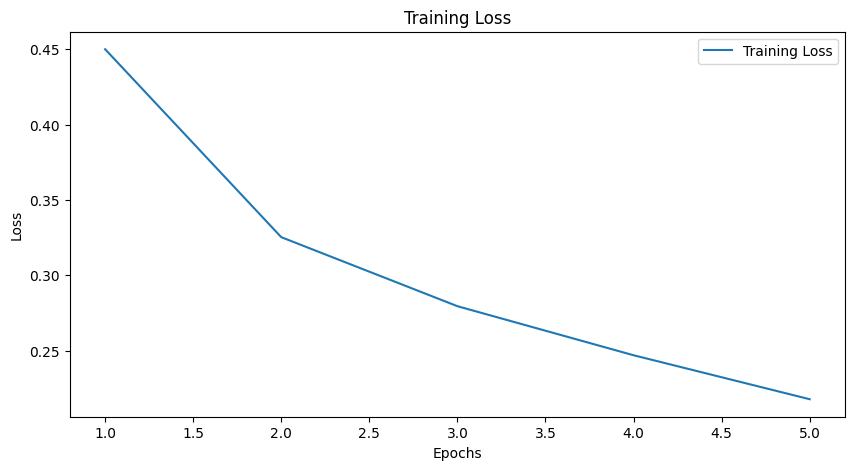

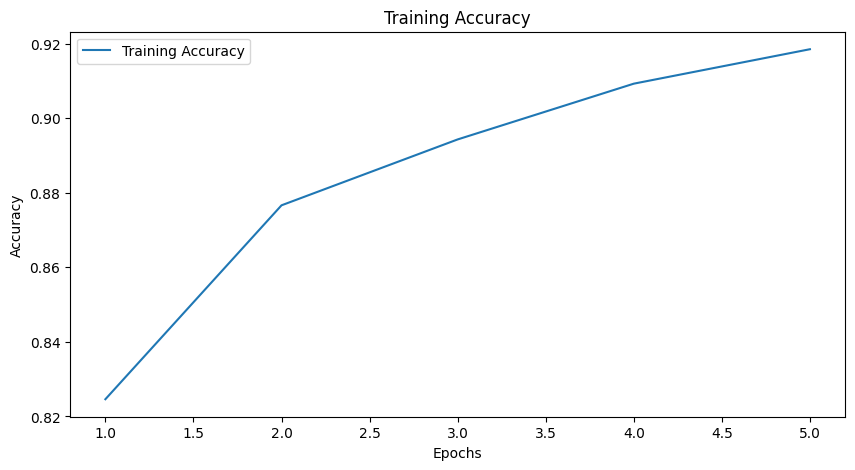

In [ ]:

criterion = nn.CrossEntropyLoss()
epochs = 5
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_losses = []
train_accuracy = []
train_precision = []
train_recall = []
train_f1 = []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_preds.extend(predicted.tolist())
        all_labels.extend(labels.tolist())

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_accuracy = correct / total
    epoch_precision = precision_score(all_labels, all_preds, average='weighted')
    epoch_recall = recall_score(all_labels, all_preds, average='weighted')
    epoch_f1 = f1_score(all_labels, all_preds, average='weighted')

    train_losses.append(epoch_loss)
    train_accuracy.append(epoch_accuracy)
    train_precision.append(epoch_precision)
    train_recall.append(epoch_recall)
    train_f1.append(epoch_f1)

    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_accuracy:.4f}")


print(f"Precision: {sum(train_precision)/len(train_precision):.4f}")
print(f"Recall: {sum(train_recall)/len(train_recall):.4f}")
print(f"F1 Score: {sum(train_f1)/len(train_f1):.4f}")

# Plotting training loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs+1), train_losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.show()

# Plotting training accuracy
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs+1), train_accuracy, label='Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')
plt.legend()
plt.show()


Epoch 1/5, Train Loss: 0.7791, Train Accuracy: 0.7670
Epoch 2/5, Train Loss: 0.7394, Train Accuracy: 0.8085
Epoch 3/5, Train Loss: 0.7262, Train Accuracy: 0.8217
Epoch 4/5, Train Loss: 0.7137, Train Accuracy: 0.8341
Epoch 5/5, Train Loss: 0.7032, Train Accuracy: 0.8449
Precision: 0.8155
Recall: 0.8152
F1 Score: 0.8152


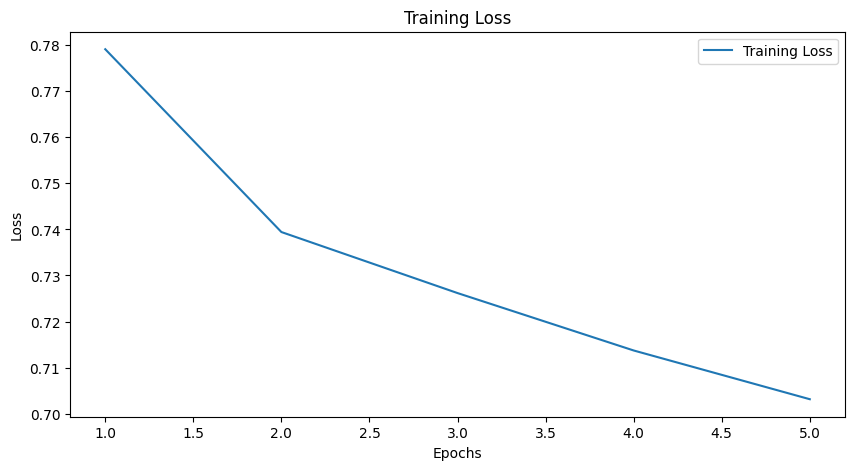

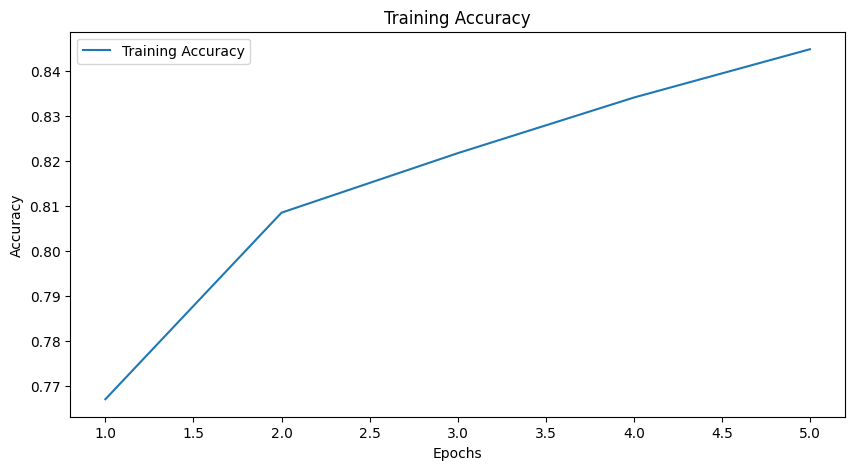

In [ ]:

criterion = nn.CrossEntropyLoss()
epochs = 5
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_losses = []
train_accuracy = []
train_precision = []
train_recall = []
train_f1 = []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_preds.extend(predicted.tolist())
        all_labels.extend(labels.tolist())

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_accuracy = correct / total
    epoch_precision = precision_score(all_labels, all_preds, average='weighted')
    epoch_recall = recall_score(all_labels, all_preds, average='weighted')
    epoch_f1 = f1_score(all_labels, all_preds, average='weighted')

    train_losses.append(epoch_loss)
    train_accuracy.append(epoch_accuracy)
    train_precision.append(epoch_precision)
    train_recall.append(epoch_recall)
    train_f1.append(epoch_f1)

    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_accuracy:.4f}")


print(f"Precision: {sum(train_precision)/len(train_precision):.4f}")
print(f"Recall: {sum(train_recall)/len(train_recall):.4f}")
print(f"F1 Score: {sum(train_f1)/len(train_f1):.4f}")

# Plotting training loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs+1), train_losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.show()

# Plotting training accuracy
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs+1), train_accuracy, label='Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')
plt.legend()
plt.show()


In [ ]:
val_losses = []
val_accuracy = []
val_precision = []
val_recall = []
val_f1 = []

for epoch in range(epochs):
    model.eval()  # Set the model to evaluation mode
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    # Iterate over the validation dataset
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_preds.extend(predicted.tolist())
            all_labels.extend(labels.tolist())

    # Calculate metrics
    epoch_loss = running_loss / len(val_loader.dataset)
    epoch_accuracy = correct / total
    epoch_precision = precision_score(all_labels, all_preds, average='weighted')
    epoch_recall = recall_score(all_labels, all_preds, average='weighted')
    epoch_f1 = f1_score(all_labels, all_preds, average='weighted')

    # Append metrics to lists
    val_losses.append(epoch_loss)
    val_accuracy.append(epoch_accuracy)
    val_precision.append(epoch_precision)
    val_recall.append(epoch_recall)
    val_f1.append(epoch_f1)

    # Print validation metrics
    print(f"Epoch {epoch+1}/{epochs}, Validation Loss: {epoch_loss:.4f}, Validation Accuracy: {epoch_accuracy:.4f}")

# Print overall validation metrics
print(f"Validation Precision: {sum(val_precision)/len(val_precision):.4f}")
print(f"Validation Recall: {sum(val_recall)/len(val_recall):.4f}")
print(f"Validation F1 Score: {sum(val_f1)/len(val_f1):.4f}")

# Plotting validation loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Validation Loss')
plt.legend()
plt.show()

# Plotting validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs+1), val_accuracy, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()
plt.show()

In [ ]:
test_losses = []
test_accuracy = []
test_precision = []
test_recall = []
test_f1 = []

for epoch in range(epochs):
    model.eval()  # Set the model to evaluation mode
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    # Iterate over the test dataset
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_preds.extend(predicted.tolist())
            all_labels.extend(labels.tolist())

    # Calculate metrics
    epoch_loss = running_loss / len(test_loader.dataset)
    epoch_accuracy = correct / total
    epoch_precision = precision_score(all_labels, all_preds, average='weighted')
    epoch_recall = recall_score(all_labels, all_preds, average='weighted')
    epoch_f1 = f1_score(all_labels, all_preds, average='weighted')

    # Append metrics to lists
    test_losses.append(epoch_loss)
    test_accuracy.append(epoch_accuracy)
    test_precision.append(epoch_precision)
    test_recall.append(epoch_recall)
    test_f1.append(epoch_f1)

    # Print test metrics
    print(f"Epoch {epoch+1}/{epochs}, Test Loss: {epoch_loss:.4f}, Test Accuracy: {epoch_accuracy:.4f}")

# Print overall test metrics
print(f"Test Precision: {sum(test_precision)/len(test_precision):.4f}")
print(f"Test Recall: {sum(test_recall)/len(test_recall):.4f}")
print(f"Test F1 Score: {sum(test_f1)/len(test_f1):.4f}")

# Plotting test loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs+1), test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Test Loss')
plt.legend()
plt.show()

# Plotting test accuracy
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs+1), test_accuracy, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Test Accuracy')
plt.legend()
plt.show()


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
NUM_EPOCHS = 5
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
test_losses = []
test_accuracies = []


for epoch in range(NUM_EPOCHS):
    # Training
    train_correct = 0
    train_total = 0
    train_loss = 0

    model.train()
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        targets = targets.squeeze().long()
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        train_total += targets.size(0)
        train_correct += (predicted == targets).sum().item()

    epoch_train_loss = train_loss / len(train_loader.dataset)
    epoch_train_accuracy = train_correct / train_total

    train_losses.append(epoch_train_loss)
    train_accuracies.append(epoch_train_accuracy)

    # Validation
    val_correct = 0
    val_total = 0
    val_loss = 0

    model.eval()
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            targets = targets.squeeze().long()
            loss = criterion(outputs, targets)
            val_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            val_total += targets.size(0)
            val_correct += (predicted == targets).sum().item()

        epoch_val_loss = val_loss / len(val_loader.dataset)
        epoch_val_accuracy = val_correct / val_total

        val_losses.append(epoch_val_loss)
        val_accuracies.append(epoch_val_accuracy)

    # Testing
    test_correct = 0
    test_total = 0
    test_loss = 0

    model.eval()
    preds_list = []
    targets_list = []
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            targets = targets.squeeze().long()
            loss = criterion(outputs, targets)
            test_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            preds_list.extend(predicted.cpu().numpy())
            targets_list.extend(targets.cpu().numpy())

            test_total += targets.size(0)
            test_correct += (predicted == targets).sum().item()

        epoch_test_loss = test_loss / len(test_loader.dataset)
        epoch_test_accuracy = test_correct / test_total

        test_losses.append(epoch_test_loss)
        test_accuracies.append(epoch_test_accuracy)

conf_matrix = confusion_matrix(targets_list, preds_list)
print("Confusion Matrix:")
print(conf_matrix)
precision = precision_score(targets_list, preds_list, average='weighted')
recall = recall_score(targets_list, preds_list, average='weighted')
f1 = f1_score(targets_list, preds_list, average='weighted')

print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))
print("F1 Score: {:.4f}".format(f1))

Confusion Matrix:
[[1400  291   91]
 [ 114 1555  150]
 [ 225  116 1458]]
Precision: 0.8185
Recall: 0.8172
F1 Score: 0.8172


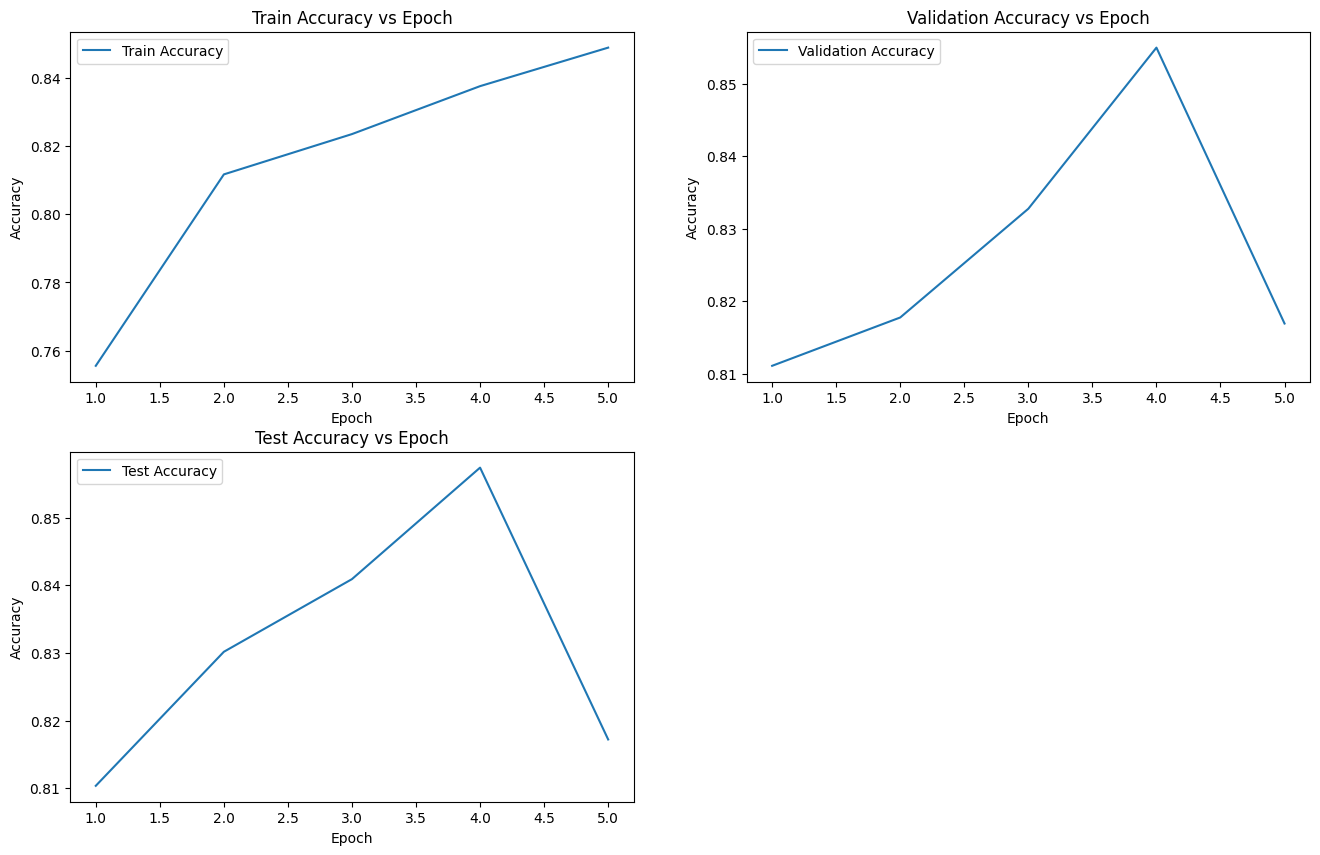

In [ ]:
plt.figure(figsize=(16, 10))
plt.subplot(2, 2, 1)
plt.plot(range(1, NUM_EPOCHS + 1), train_accuracies, label='Train Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train Accuracy vs Epoch')
plt.legend()

# Plot validation accuracy
plt.subplot(2, 2, 2)
plt.plot(range(1, NUM_EPOCHS + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy vs Epoch')
plt.legend()

# Plot test accuracy
plt.subplot(2, 2, 3)
plt.plot(range(1, NUM_EPOCHS + 1), test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Test Accuracy vs Epoch')
plt.legend()


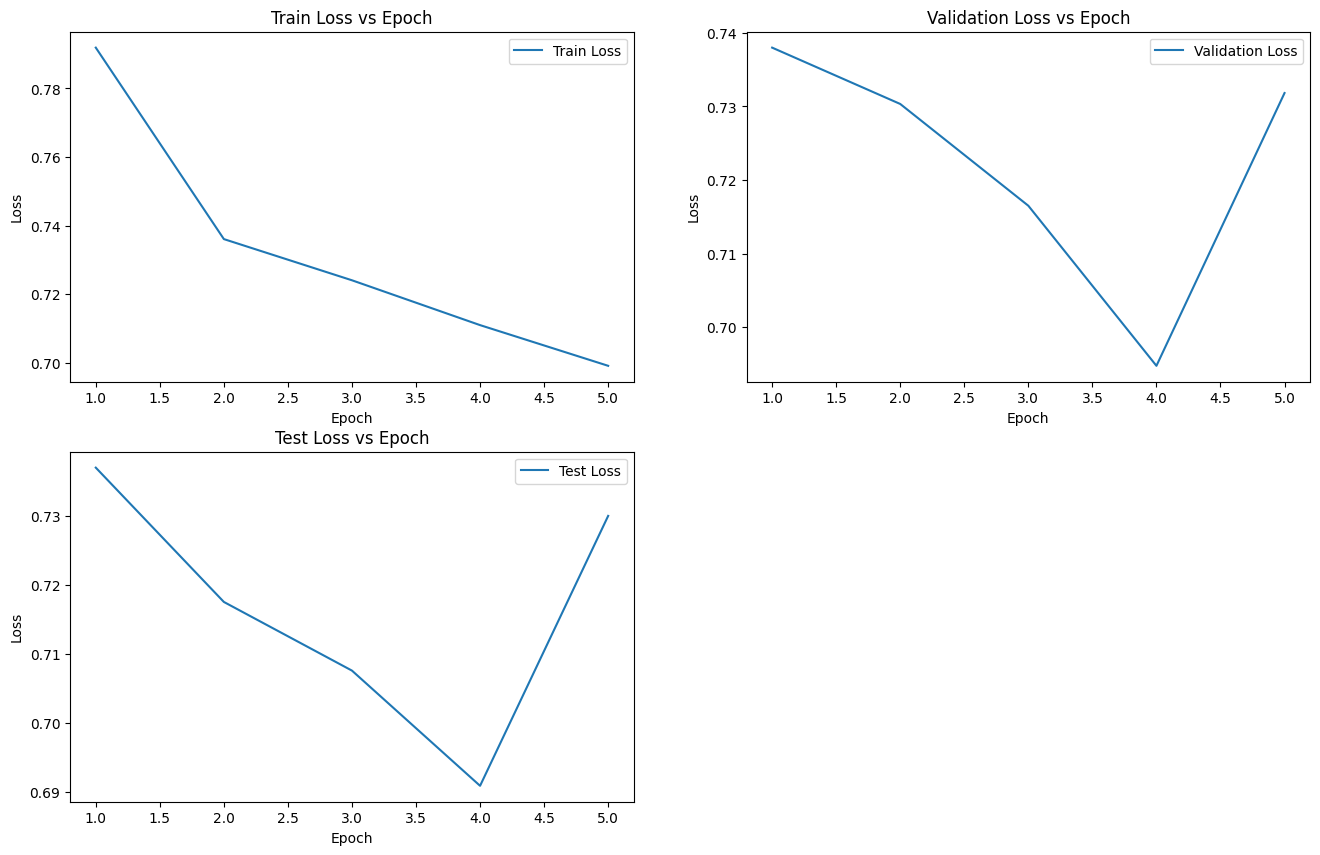

In [ ]:
# Plot train loss
plt.figure(figsize=(16, 10))
plt.subplot(2, 2, 1)
plt.plot(range(1, NUM_EPOCHS + 1), train_losses, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train Loss vs Epoch')
plt.legend()

# Plot validation loss
plt.subplot(2, 2, 2)
plt.plot(range(1, NUM_EPOCHS + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Validation Loss vs Epoch')
plt.legend()

# Plot test loss
plt.subplot(2, 2, 3)
plt.plot(range(1, NUM_EPOCHS + 1), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Test Loss vs Epoch')
plt.legend()

In [ ]:
#Print Accuracies:

print(f"Train Accuracies: {train_accuracies[-1]*100}%")
print(f"Validation Accuracies: {val_accuracies[-1]*100}%")
print(f"Test Accuracies: {test_accuracies[-1]*100}%")

Train Accuracies: 84.88095238095238%
Validation Accuracies: 81.69444444444444%
Test Accuracies: 81.72222222222221%


In [ ]:
#Print Loss:
print(f"Train Loss: {train_losses[-1]}")
print(f"Validation Loss: {val_losses[-1]}")
print(f"Test Loss: {test_losses[-1]}")

Train Loss: 0.699107855842227
Validation Loss: 0.73182090388404
Test Loss: 0.7300489725889983


In [ ]:
torch.save(model.state_dict(), 'ResNet_basic.pth')

**Apply L2 Regularization**

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

In [ ]:
NUM_EPOCHS = 12
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
test_losses = []
test_accuracies = []


for epoch in range(NUM_EPOCHS):
    # Training
    train_correct = 0
    train_total = 0
    train_loss = 0

    model.train()
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        targets = targets.squeeze().long()
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        train_total += targets.size(0)
        train_correct += (predicted == targets).sum().item()

    epoch_train_loss = train_loss / len(train_loader.dataset)
    epoch_train_accuracy = train_correct / train_total

    train_losses.append(epoch_train_loss)
    train_accuracies.append(epoch_train_accuracy)

    # Validation
    val_correct = 0
    val_total = 0
    val_loss = 0

    model.eval()
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            targets = targets.squeeze().long()
            loss = criterion(outputs, targets)
            val_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            val_total += targets.size(0)
            val_correct += (predicted == targets).sum().item()

        epoch_val_loss = val_loss / len(val_loader.dataset)
        epoch_val_accuracy = val_correct / val_total

        val_losses.append(epoch_val_loss)
        val_accuracies.append(epoch_val_accuracy)

    # Testing
    test_correct = 0
    test_total = 0
    test_loss = 0

    model.eval()
    preds_list = []
    targets_list = []
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            targets = targets.squeeze().long()
            loss = criterion(outputs, targets)
            test_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            preds_list.extend(predicted.cpu().numpy())
            targets_list.extend(targets.cpu().numpy())

            test_total += targets.size(0)
            test_correct += (predicted == targets).sum().item()

        epoch_test_loss = test_loss / len(test_loader.dataset)
        epoch_test_accuracy = test_correct / test_total

        test_losses.append(epoch_test_loss)
        test_accuracies.append(epoch_test_accuracy)

conf_matrix = confusion_matrix(targets_list, preds_list)
print("Confusion Matrix:")
print(conf_matrix)
precision = precision_score(targets_list, preds_list, average='weighted')
recall = recall_score(targets_list, preds_list, average='weighted')
f1 = f1_score(targets_list, preds_list, average='weighted')

print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))
print("F1 Score: {:.4f}".format(f1))

Confusion Matrix:
[[1480  135  167]
 [ 132 1615   72]
 [  46   57 1696]]
Precision: 0.8876
Recall: 0.8872
F1 Score: 0.8867


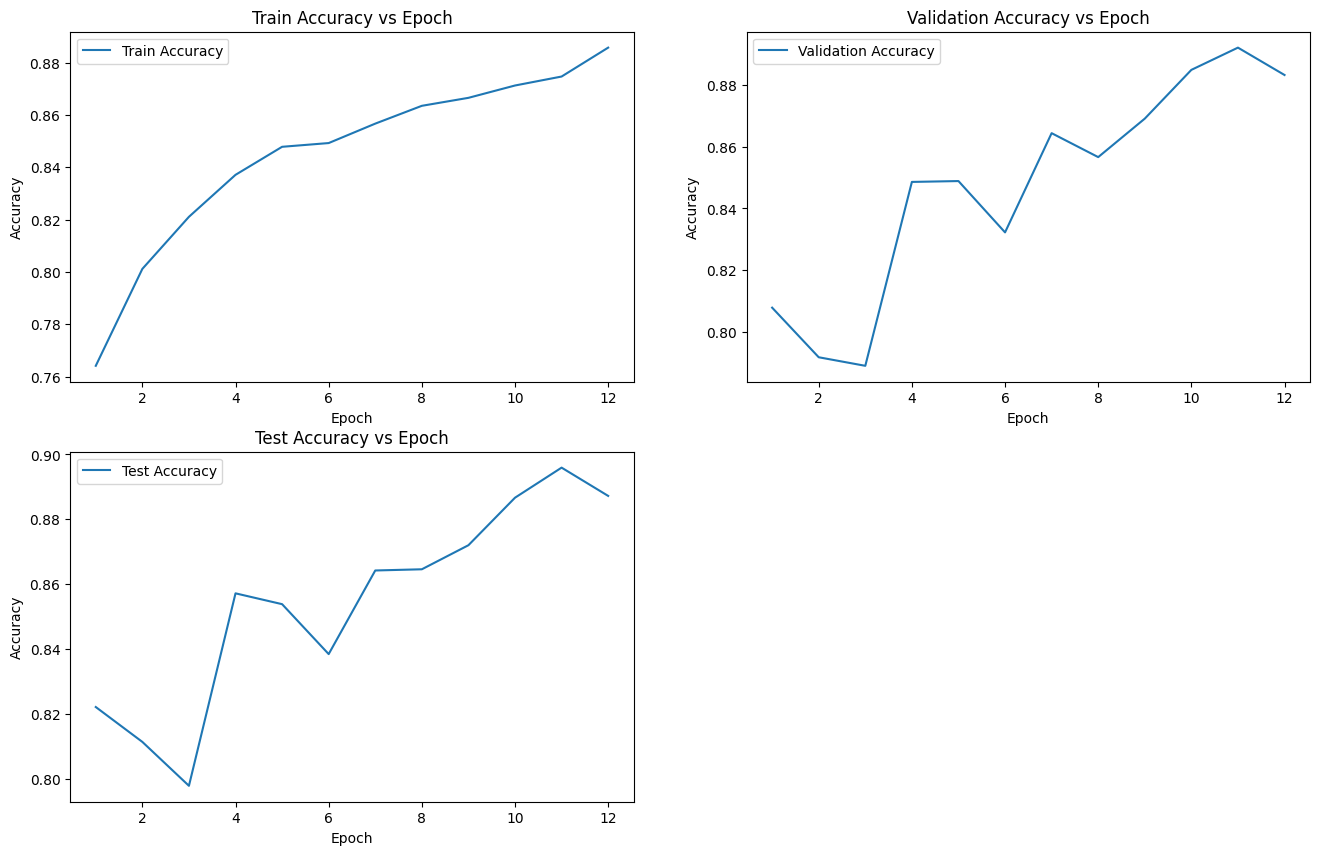

In [ ]:
plt.figure(figsize=(16, 10))
plt.subplot(2, 2, 1)
plt.plot(range(1, NUM_EPOCHS + 1), train_accuracies, label='Train Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train Accuracy vs Epoch')
plt.legend()

# Plot validation accuracy
plt.subplot(2, 2, 2)
plt.plot(range(1, NUM_EPOCHS + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy vs Epoch')
plt.legend()

# Plot test accuracy
plt.subplot(2, 2, 3)
plt.plot(range(1, NUM_EPOCHS + 1), test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Test Accuracy vs Epoch')
plt.legend()


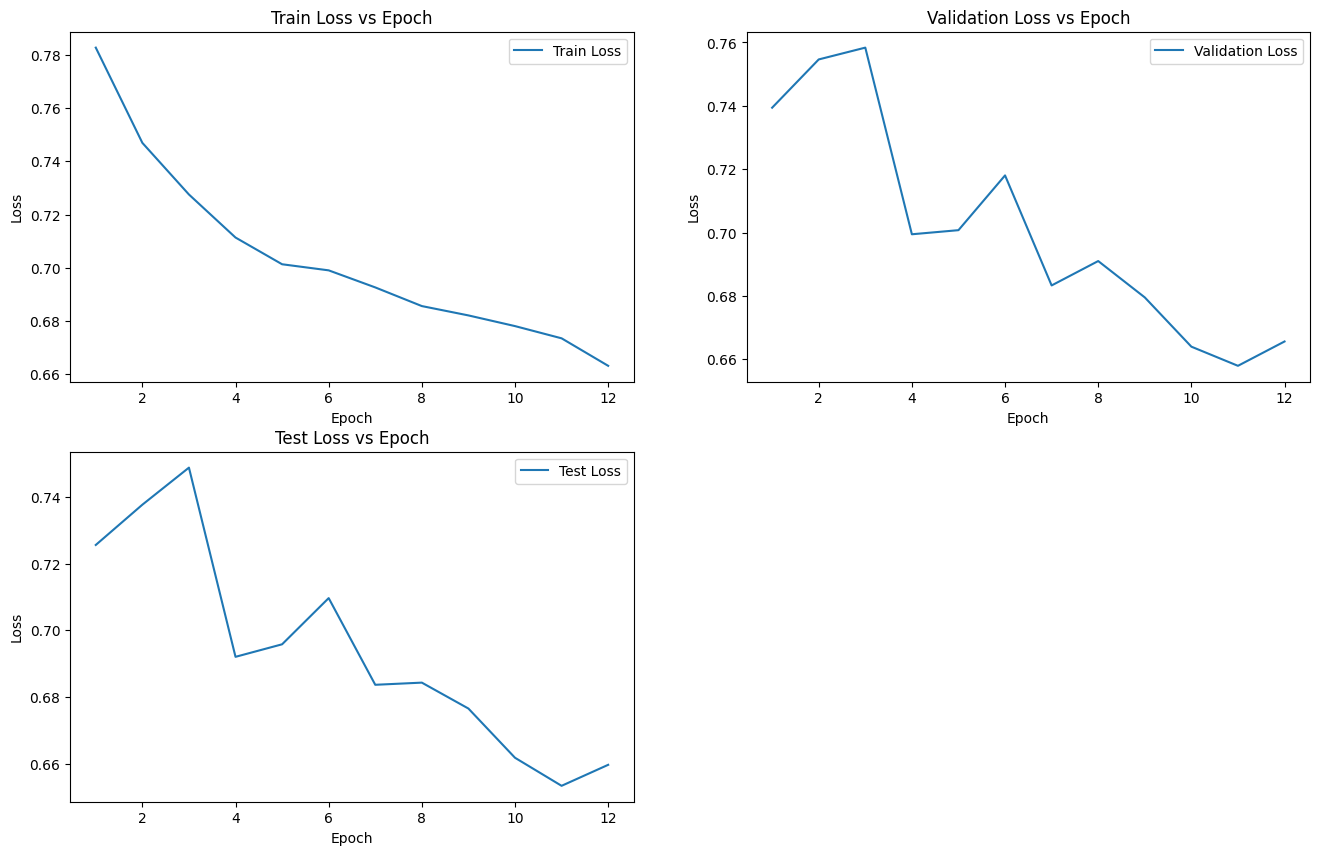

In [ ]:
# Plot train loss
plt.figure(figsize=(16, 10))
plt.subplot(2, 2, 1)
plt.plot(range(1, NUM_EPOCHS + 1), train_losses, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train Loss vs Epoch')
plt.legend()

# Plot validation loss
plt.subplot(2, 2, 2)
plt.plot(range(1, NUM_EPOCHS + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Validation Loss vs Epoch')
plt.legend()

# Plot test loss
plt.subplot(2, 2, 3)
plt.plot(range(1, NUM_EPOCHS + 1), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Test Loss vs Epoch')
plt.legend()

In [ ]:
#Print Accuracies:

print(f"Train Accuracies: {train_accuracies[-1]*100}%")
print(f"Validation Accuracies: {val_accuracies[-1]*100}%")
print(f"Test Accuracies: {test_accuracies[-1]*100}%")

Train Accuracies: 88.57619047619048%
Validation Accuracies: 88.33333333333333%
Test Accuracies: 88.72222222222223%


In [ ]:
#Print Loss:
print(f"Train Loss: {train_losses[-1]}")
print(f"Validation Loss: {val_losses[-1]}")
print(f"Test Loss: {test_losses[-1]}")

Train Loss: 0.6632020957583473
Validation Loss: 0.6656107680002848
Test Loss: 0.6597307134557653


In [ ]:
torch.save(model.state_dict(), 'ResNet_l2.pth')

In [ ]:
dropout_prob = 0.2

**Batch Normalization**

In [ ]:
class Building_block(nn.Module):

    def __init__(self, in_channels, out_channels, stride=1):
        super(Building_block, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)  # Batch Normalization
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)  # Batch Normalization
        self.conv_str2 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride)
        self.bn3 = nn.BatchNorm2d(out_channels)  # Batch Normalization
        self.relu = nn.ReLU()
        self.stride = stride

    def forward(self, x):
        inp_val = x

        x = self.conv1(x)
        x = self.bn1(x)  # Batch Normalization
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)  # Batch Normalization

        if self.stride == 2:
            inp_val = self.conv_str2(inp_val)
            inp_val = self.bn3(inp_val)  # Batch Normalization

        # Match dimension
        if inp_val is not None and inp_val.shape[-1] != x.shape[-1]:
            inp_val = helper_function(x, inp_val)
        x = x + inp_val
        x = self.relu(x)
        return x

class ResNet18(nn.Module):

    def __init__(self, img_channels, num_classes):

        super(ResNet18, self).__init__()
        self.conv1 = nn.Conv2d(img_channels, 64, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm2d(64)  # Batch Normalization
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.softmax = nn.Softmax(dim=1)

        # Layer 1
        self.layer1 = nn.Sequential(
            Building_block(64, 64, stride=1),
            Building_block(64, 64)
        )

        # Layer 2
        self.layer2 = nn.Sequential(
            Building_block(64, 128, stride=2),
            Building_block(128, 128)
        )

        # Layer 3
        self.layer3 = nn.Sequential(
            Building_block(128, 256, stride=2),
            Building_block(256, 256)
        )

        # Layer 4
        self.layer4 = nn.Sequential(
            Building_block(256, 512, stride=2),
            Building_block(512, 512)
        )

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def forward(self, x):

        x = self.conv1(x)
        x = self.bn1(x)  # Batch Normalization
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.shape[0], -1)
        x = self.fc(x)
        x = self.softmax(x)
        return x

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
NUM_EPOCHS = 8
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
test_losses = []
test_accuracies = []


for epoch in range(NUM_EPOCHS):
    # Training
    train_correct = 0
    train_total = 0
    train_loss = 0

    model.train()
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        targets = targets.squeeze().long()
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        train_total += targets.size(0)
        train_correct += (predicted == targets).sum().item()

    epoch_train_loss = train_loss / len(train_loader.dataset)
    epoch_train_accuracy = train_correct / train_total

    train_losses.append(epoch_train_loss)
    train_accuracies.append(epoch_train_accuracy)

    # Validation
    val_correct = 0
    val_total = 0
    val_loss = 0

    model.eval()
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            targets = targets.squeeze().long()
            loss = criterion(outputs, targets)
            val_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            val_total += targets.size(0)
            val_correct += (predicted == targets).sum().item()

        epoch_val_loss = val_loss / len(val_loader.dataset)
        epoch_val_accuracy = val_correct / val_total

        val_losses.append(epoch_val_loss)
        val_accuracies.append(epoch_val_accuracy)

    # Testing
    test_correct = 0
    test_total = 0
    test_loss = 0

    model.eval()
    preds_list = []
    targets_list = []
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            targets = targets.squeeze().long()
            loss = criterion(outputs, targets)
            test_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            preds_list.extend(predicted.cpu().numpy())
            targets_list.extend(targets.cpu().numpy())

            test_total += targets.size(0)
            test_correct += (predicted == targets).sum().item()

        epoch_test_loss = test_loss / len(test_loader.dataset)
        epoch_test_accuracy = test_correct / test_total

        test_losses.append(epoch_test_loss)
        test_accuracies.append(epoch_test_accuracy)

conf_matrix = confusion_matrix(targets_list, preds_list)
print("Confusion Matrix:")
print(conf_matrix)
precision = precision_score(targets_list, preds_list, average='weighted')
recall = recall_score(targets_list, preds_list, average='weighted')
f1 = f1_score(targets_list, preds_list, average='weighted')

print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))
print("F1 Score: {:.4f}".format(f1))

Confusion Matrix:
[[1582  147   53]
 [ 158 1618   43]
 [  86   58 1655]]
Precision: 0.8998
Recall: 0.8991
F1 Score: 0.8993


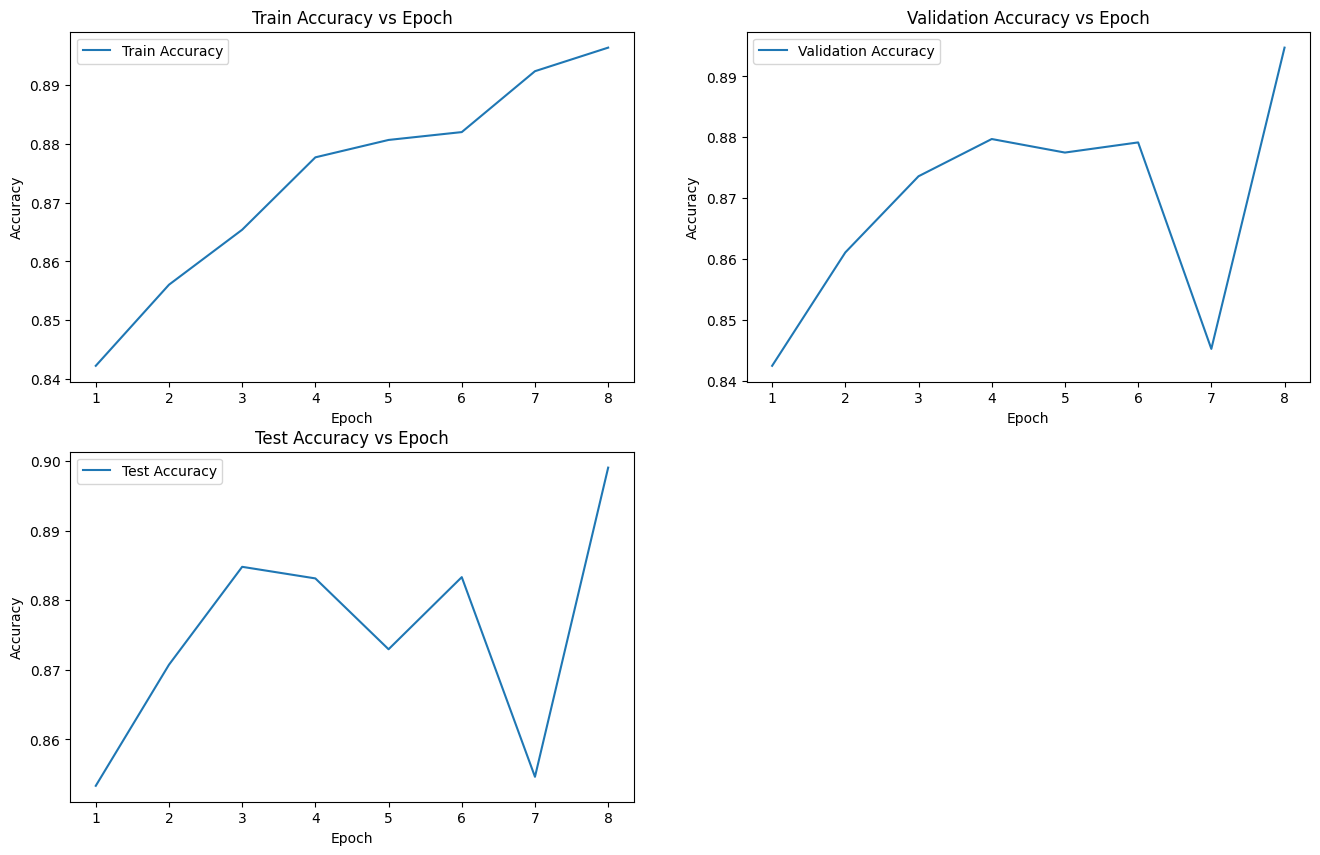

In [ ]:
plt.figure(figsize=(16, 10))
plt.subplot(2, 2, 1)
plt.plot(range(1, NUM_EPOCHS + 1), train_accuracies, label='Train Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train Accuracy vs Epoch')
plt.legend()

# Plot validation accuracy
plt.subplot(2, 2, 2)
plt.plot(range(1, NUM_EPOCHS + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy vs Epoch')
plt.legend()

# Plot test accuracy
plt.subplot(2, 2, 3)
plt.plot(range(1, NUM_EPOCHS + 1), test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Test Accuracy vs Epoch')
plt.legend()


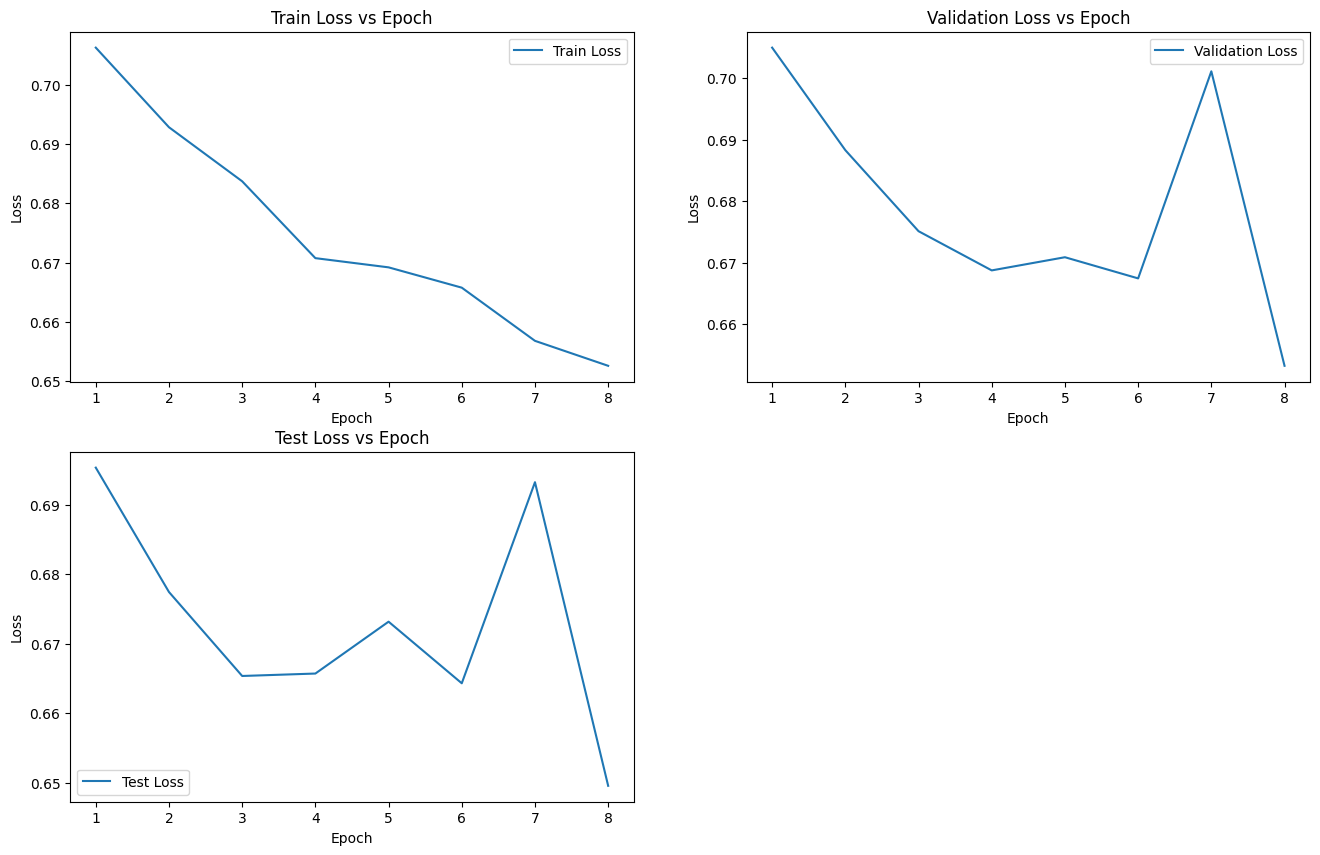

In [ ]:
# Plot train loss
plt.figure(figsize=(16, 10))
plt.subplot(2, 2, 1)
plt.plot(range(1, NUM_EPOCHS + 1), train_losses, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train Loss vs Epoch')
plt.legend()

# Plot validation loss
plt.subplot(2, 2, 2)
plt.plot(range(1, NUM_EPOCHS + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Validation Loss vs Epoch')
plt.legend()

# Plot test loss
plt.subplot(2, 2, 3)
plt.plot(range(1, NUM_EPOCHS + 1), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Test Loss vs Epoch')
plt.legend()

In [ ]:
#Print Accuracies:

print(f"Train Accuracies: {train_accuracies[-1]*100}%")
print(f"Validation Accuracies: {val_accuracies[-1]*100}%")
print(f"Test Accuracies: {test_accuracies[-1]*100}%")

Train Accuracies: 89.62857142857142%
Validation Accuracies: 89.47222222222221%
Test Accuracies: 89.9074074074074%


In [ ]:
#Print Loss:
print(f"Train Loss: {train_losses[-1]}")
print(f"Validation Loss: {val_losses[-1]}")
print(f"Test Loss: {test_losses[-1]}")

Train Loss: 0.6525589999925523
Validation Loss: 0.6532533815171984
Test Loss: 0.6495481295055813


In [ ]:
torch.save(model.state_dict(), 'ResNet_bn.pth')

In [ ]:
from google.colab import files
files.download('ResNet_l2.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
files.download('ResNet_bn.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>